In [1]:
import pandas as pd
import requests
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from numpy import mean
from numpy import std

# ML libraries
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Data Import

In [2]:
# Importing dataset from URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00225/Indian%20Liver%20Patient%20Dataset%20(ILPD).csv"
response = requests.get(url, verify=False)

# Define column names
headers = ['Age', 'Gender', 'Total Bilirubin (TB)', 'Direct Bilirubin (DB)', 'Alkaline Phosphotase (Alkphos)', 
           'Alamine Aminotransferase (SGPT)', 'Aspartate Aminotransferase (SGOT)', 'Total Protiens (TP)', 
           'Albumin (ALB)', 'Albumin and Globulin Ratio (AGR)', 'Target']

# Create dataframe
df = pd.read_csv(io.BytesIO(response.content), names=headers, header=0)
df.head(5)


,Age,Gender,Total Bilirubin (TB),Direct Bilirubin (DB),Alkaline Phosphotase (Alkphos),Alamine Aminotransferase (SGPT),Aspartate Aminotransferase (SGOT),Total Protiens (TP),Albumin (ALB),Albumin and Globulin Ratio (AGR),Target
0,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
1,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
2,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
3,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1
4,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.30,1


### Table: Dataset Outline

In [3]:
# Format dataset outline table with serial number index
data = {
        'S. No': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
        'Attribute Name': ['age', 'gender', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/G Ratio', 'Target'],
        'Attribute Description': ['Age of the patient', 'Gender of the patient', 'Total Bilirubin', 'Direct Bilirubin', 'Alkaline Phosphotase',
                                  'Alamine Aminotransferase', 'Aspartate Aminotransferase', 'Total Protiens', 'Albumin',
                                  'Albumin and Globulin Ratio', 'Disease/Non-Disease'],
        'Data Type': ['Integer', 'String', 'Real Number', 'Real Number', 'Integer', 'Integer', 'Integer', 'Real Number',
                      'Real Number', 'Real Number', 'Binary Integer']
        }

data_outline = pd.DataFrame(data)
data_outline


,S. No,Attribute Name,Attribute Description,Data Type
0,1,age,Age of the patient,Integer
1,2,gender,Gender of the patient,String
2,3,TB,Total Bilirubin,Real Number
3,4,DB,Direct Bilirubin,Real Number
4,5,Alkphos,Alkaline Phosphotase,Integer
5,6,Sgpt,Alamine Aminotransferase,Integer
6,7,Sgot,Aspartate Aminotransferase,Integer
7,8,TP,Total Protiens,Real Number
8,9,ALB,Albumin,Real Number
9,10,A/G Ratio,Albumin and Globulin Ratio,Real Number


In [4]:
# Print dataset shape
print(f"Shape of the Dataset: {df.shape}")

Shape of the Dataset: (582, 11)


In [5]:
# View table information, such as null count, datatypes etc.
df.info() # gender data type needs to changed to int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                582 non-null    int64  
 1   Gender                             582 non-null    object 
 2   Total Bilirubin (TB)               582 non-null    float64
 3   Direct Bilirubin (DB)              582 non-null    float64
 4   Alkaline Phosphotase (Alkphos)     582 non-null    int64  
 5   Alamine Aminotransferase (SGPT)    582 non-null    int64  
 6   Aspartate Aminotransferase (SGOT)  582 non-null    int64  
 7   Total Protiens (TP)                582 non-null    float64
 8   Albumin (ALB)                      582 non-null    float64
 9   Albumin and Globulin Ratio (AGR)   578 non-null    float64
 10  Target                             582 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.1+ KB


## Descriptive Statistics

In [6]:
# Show distribution of gender with the target variable.
# There is a greater number of diseased than non-diseased individuals.
df.groupby(['Gender', 'Target']).size()

Gender  Target
Female  1          91
        2          50
Male    1         324
        2         117
dtype: int64

In [7]:
# Descriptive statistics
df.groupby(['Target']).mean()

,Age,Total Bilirubin (TB),Direct Bilirubin (DB),Alkaline Phosphotase (Alkphos),Alamine Aminotransferase (SGPT),Aspartate Aminotransferase (SGOT),Total Protiens (TP),Albumin (ALB),Albumin and Globulin Ratio (AGR)
Target,,,,,,,,,
1,46.108434,4.172771,1.927952,319.325301,99.807229,137.987952,6.458313,3.060000,0.914213
2,41.239521,1.142515,0.396407,219.754491,33.652695,40.688623,6.543114,3.344311,1.029576


In [8]:
# Output dataset statisitics for each column
stats_df = df.describe().transpose()
stats_df['count'] = stats_df['count'].astype(int)
stats_df

,count,mean,std,min,25%,50%,75%,max
Age,582,44.711340,16.181921,4.0,33.00,45.00,57.75,90.0
Total Bilirubin (TB),582,3.303265,6.213926,0.4,0.80,1.00,2.60,75.0
Direct Bilirubin (DB),582,1.488488,2.810324,0.1,0.20,0.30,1.30,19.7
Alkaline Phosphotase (Alkphos),582,290.754296,243.108929,63.0,175.25,208.00,298.00,2110.0
Alamine Aminotransferase (SGPT),582,80.824742,182.757696,10.0,23.00,35.00,60.75,2000.0
Aspartate Aminotransferase (SGOT),582,110.068729,289.141876,10.0,25.00,42.00,87.00,4929.0
Total Protiens (TP),582,6.482646,1.086306,2.7,5.80,6.60,7.20,9.6
Albumin (ALB),582,3.141581,0.796176,0.9,2.60,3.10,3.80,5.5
Albumin and Globulin Ratio (AGR),578,0.947145,0.319863,0.3,0.70,0.94,1.10,2.8
Target,582,1.286942,0.452723,1.0,1.00,1.00,2.00,2.0


In [9]:
# Function to calculate confidence intervals for numeric datatype columns
def confidence_interval(x):
    mean_val = np.mean(x)
    n = len(x)
    std_val = np.std(x)
    return np.round((mean_val - (1.96 * (std_val / np.sqrt(n))),
            mean_val + (1.96 * (std_val / np.sqrt(n)))), 3)

In [10]:
# Create confidence intervals for numerical features
ci = []

# List of numeric columns
numeric_headers = ['Age', 'Total Bilirubin (TB)', 'Direct Bilirubin (DB)', 'Alkaline Phosphotase (Alkphos)', 
                     'Alamine Aminotransferase (SGPT)', 'Aspartate Aminotransferase (SGOT)', 'Total Protiens (TP)', 
                     'Albumin (ALB)', 'Albumin and Globulin Ratio (AGR)', 'Target']

for header in numeric_headers:
    if header == 'Target':
        ci.append('-')
    else:
        ci.append(confidence_interval(df[header]))


In [11]:
# Table formatting
index_list = ['Gender', 'Target']
stats_df['95% Confidence Interval for Mean'] = ci

# Rounding decimal places
stats_df['mean'] = stats_df['mean'].apply(lambda x: np.round(x, 3))
stats_df['std'] = stats_df['std'].apply(lambda x: np.round(x, 3))

# Replace binary integer statistics with '-'
stats_df.loc[stats_df.index.isin(index_list), ['mean', 'std', '25%', '50%', '75%']] = '-'

# Summary table
stats_summary = stats_df[['count', 'mean', '95% Confidence Interval for Mean', 'std', 'min', 'max']]

In [12]:
# Adding Gender to summary table
stats_summary.loc['Gender'] = [len(df['Gender']), '-', '-', '-', '-', '-']

# Reindexing 
stats_summary = stats_summary.reindex(['Age', 'Gender', 'Total Bilirubin (TB)', 'Direct Bilirubin (DB)', 'Alkaline Phosphotase (Alkphos)', 
           'Alamine Aminotransferase (SGPT)', 'Aspartate Aminotransferase (SGOT)', 'Total Protiens (TP)', 
           'Albumin (ALB)', 'Albumin and Globulin Ratio (AGR)', 'Target'])

# Address decimal places for integer rows
stats_summary[['min', 'max']] = stats_summary[['min', 'max']].astype(str)

# Replace decimal point for integer values
pattern = re.compile(r'\.0$')
stats_summary['min'] = stats_summary['min'].str.replace(pattern, '')
stats_summary['max'] = stats_summary['max'].str.replace(pattern, '')

In [13]:
# Rename columns
stats_summary = stats_summary.rename(columns={'count': 'N',
                                              'mean': 'Mean',
                                              'std': 'Std. Deviation',
                                              'min': 'Minimum',
                                              'max': 'Maximum'})

# Rename Axis
stats_summary = stats_summary.rename_axis('Attribute Name')

# Reset index
stats_summary = stats_summary.reset_index()
stats_summary


,Attribute Name,N,Mean,95% Confidence Interval for Mean,Std. Deviation,Minimum,Maximum
0,Age,582,44.711,"[43.398, 46.025]",16.182,4,90
1,Gender,582,-,-,-,-,-
2,Total Bilirubin (TB),582,3.303,"[2.799, 3.808]",6.214,0.4,75
3,Direct Bilirubin (DB),582,1.488,"[1.26, 1.717]",2.81,0.1,19.7
4,Alkaline Phosphotase (Alkphos),582,290.754,"[271.02, 310.489]",243.109,63,2110
5,Alamine Aminotransferase (SGPT),582,80.825,"[65.989, 95.66]",182.758,10,2000
6,Aspartate Aminotransferase (SGOT),582,110.069,"[86.598, 133.54]",289.142,10,4929
7,Total Protiens (TP),582,6.483,"[6.394, 6.571]",1.086,2.7,9.6
8,Albumin (ALB),582,3.142,"[3.077, 3.206]",0.796,0.9,5.5
9,Albumin and Globulin Ratio (AGR),578,0.947,"[0.921, 0.973]",0.32,0.3,2.8


## Data Exploration and Processing

In [14]:
# Checking for null values - AGR contains 4 null entries
df.isnull().sum()

Age                                  0
Gender                               0
Total Bilirubin (TB)                 0
Direct Bilirubin (DB)                0
Alkaline Phosphotase (Alkphos)       0
Alamine Aminotransferase (SGPT)      0
Aspartate Aminotransferase (SGOT)    0
Total Protiens (TP)                  0
Albumin (ALB)                        0
Albumin and Globulin Ratio (AGR)     4
Target                               0
dtype: int64

In [15]:
# Resolving null values.
# AGR doesn't have a big effect on target judging by the mean as shown by descriptive statistics in cell [7]
df['Albumin and Globulin Ratio (AGR)'].fillna(df['Albumin and Globulin Ratio (AGR)'].mean(), inplace=True)

In [16]:
# Checking for null values -  no null values
df.isnull().sum()

Age                                  0
Gender                               0
Total Bilirubin (TB)                 0
Direct Bilirubin (DB)                0
Alkaline Phosphotase (Alkphos)       0
Alamine Aminotransferase (SGPT)      0
Aspartate Aminotransferase (SGOT)    0
Total Protiens (TP)                  0
Albumin (ALB)                        0
Albumin and Globulin Ratio (AGR)     0
Target                               0
dtype: int64

In [17]:
# Recode target variables 
tar_mapping = {2:0, 1:1}
df['Target'] = df['Target'].map(tar_mapping)

# Encode gender to integer variable
gender_mapping = {'Male': 1, 'Female': 0}
df['Gender'] = df['Gender'].map(gender_mapping)


In [18]:
# Check target variable counts - shows unbalanced dataset for the target variable
df['Target'].value_counts()

1    415
0    167
Name: Target, dtype: int64

In [19]:
# Check null counts, and data types 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                582 non-null    int64  
 1   Gender                             582 non-null    int64  
 2   Total Bilirubin (TB)               582 non-null    float64
 3   Direct Bilirubin (DB)              582 non-null    float64
 4   Alkaline Phosphotase (Alkphos)     582 non-null    int64  
 5   Alamine Aminotransferase (SGPT)    582 non-null    int64  
 6   Aspartate Aminotransferase (SGOT)  582 non-null    int64  
 7   Total Protiens (TP)                582 non-null    float64
 8   Albumin (ALB)                      582 non-null    float64
 9   Albumin and Globulin Ratio (AGR)   582 non-null    float64
 10  Target                             582 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 50.1 KB


### Feature Correlation

In [20]:
# Renaming columns to format correlation heatmap in space efficient manner
df_rename = df.rename(columns={'Total Bilirubin (TB)': 'TB',
                               'Direct Bilirubin (DB)': 'DB',
                               'Alkaline Phosphotase (Alkphos)': 'Alkphos',
                               'Alamine Aminotransferase (SGPT)': 'SGPT',
                               'Aspartate Aminotransferase (SGOT)': 'SGOT',
                               'Total Protiens (TP)': 'TP',
                               'Albumin (ALB)': 'ALB',
                               'Albumin and Globulin Ratio (AGR)': 'AGR'                  
                                })

In [21]:
# Create correlation matrix
df_corr = pd.DataFrame(df_rename.corr())
df_corr

,Age,Gender,TB,DB,Alkphos,SGPT,SGOT,TP,ALB,AGR,Target
Age,1.000000,0.060595,0.012683,0.008605,0.081465,-0.086245,-0.019252,-0.188357,-0.266721,-0.216067,0.136218
Gender,0.060595,1.000000,0.088272,0.099227,-0.028870,0.081485,0.079592,-0.088479,-0.093450,-0.003863,0.084590
TB,0.012683,0.088272,1.000000,0.874578,0.206425,0.213865,0.237659,-0.007891,-0.222148,-0.206302,0.220773
DB,0.008605,0.099227,0.874578,1.000000,0.234662,0.233667,0.257350,0.000109,-0.228417,-0.200176,0.246721
Alkphos,0.081465,-0.028870,0.206425,0.234662,1.000000,0.125453,0.167003,-0.028307,-0.165338,-0.234110,0.185423
SGPT,-0.086245,0.081485,0.213865,0.233667,0.125453,1.000000,0.791926,-0.042348,-0.029625,-0.002465,0.163876
SGOT,-0.019252,0.079592,0.237659,0.257350,0.167003,0.791926,1.000000,-0.025490,-0.085192,-0.070113,0.152346
TP,-0.188357,-0.088479,-0.007891,0.000109,-0.028307,-0.042348,-0.025490,1.000000,0.784038,0.234000,-0.035341
ALB,-0.266721,-0.093450,-0.222148,-0.228417,-0.165338,-0.029625,-0.085192,0.784038,1.000000,0.686410,-0.161666
AGR,-0.216067,-0.003863,-0.206302,-0.200176,-0.234110,-0.002465,-0.070113,0.234000,0.686410,1.000000,-0.162218


Text(0.5, 1.0, 'Correlation Heatmap')

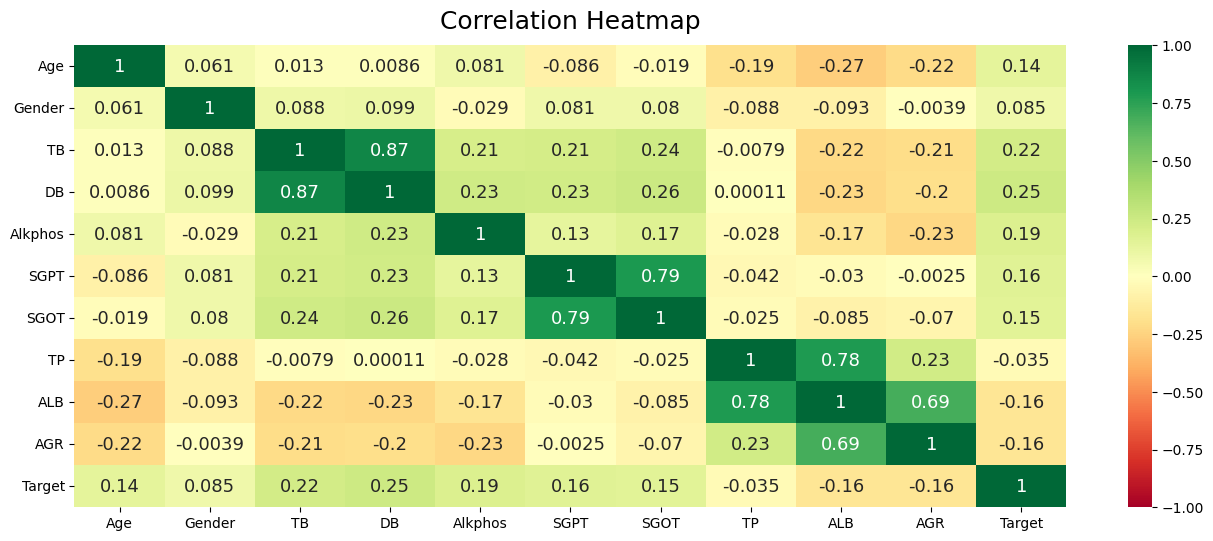

In [22]:
# Plotting correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_corr, vmin=-1, vmax=1, annot=True, cmap="RdYlGn", annot_kws={"fontsize":13})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

In [23]:
# Saving heatmap
fig = heatmap.get_figure()
fig.savefig('correlation-heatmap.png')

In [24]:
# Correlating features with target variable

# Ahow only absolute correlation value
df_corr['Target Correlations'] = df_corr['Target'].abs() 

# Select only last column containing correlations with the target
df_corr = df_corr.iloc[:, -1:]

# Sort by correlation value
df_corr.sort_values(by='Target Correlations', ascending=False, inplace=True)

# Resetting index
df_corr.reset_index(level=0, inplace=True) 

# Rename columns
df_corr.rename(columns = {'level_0':'All Rank', 'index':'Feature'}, inplace=True)
df_corr

,Feature,Target Correlations
0,Target,1.000000
1,DB,0.246721
2,TB,0.220773
3,Alkphos,0.185423
4,SGPT,0.163876
5,AGR,0.162218
6,ALB,0.161666
7,SGOT,0.152346
8,Age,0.136218
9,Gender,0.084590


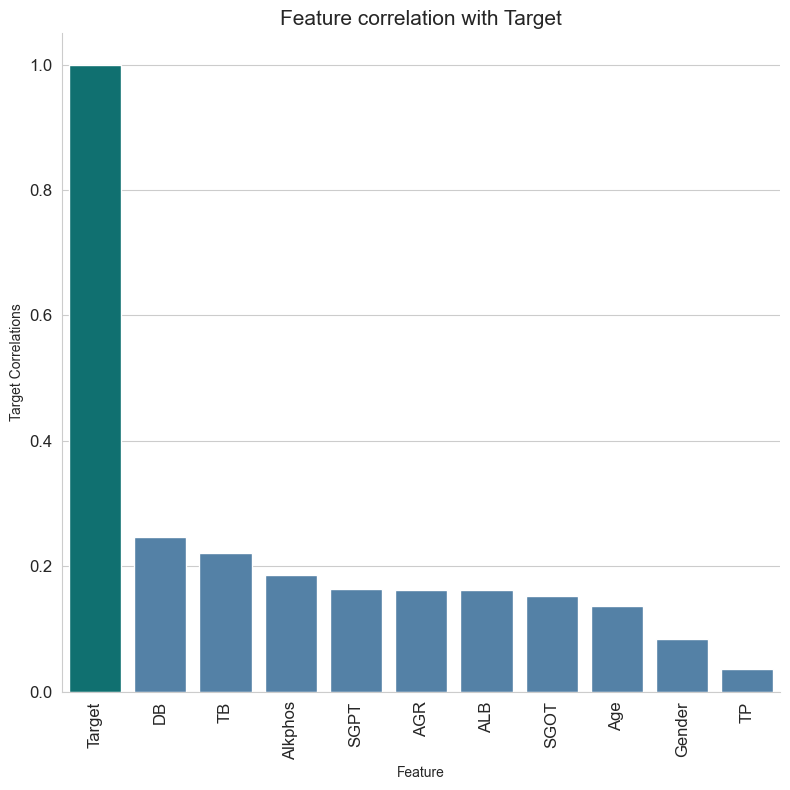

In [25]:
# Plot correlations between the sales target feature and all other variables
sns.set_style("whitegrid")
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()

cols = ['teal' if (val == 'Target') else 'steelblue' for val in df_corr['Feature']]
sns.barplot(df_corr, x='Feature', y='Target Correlations', palette=cols )
plt.title('Feature correlation with Target', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.tight_layout()

In [26]:
# Save correlation bar graph
fig.savefig('feature-correlations.png')

### Box Plots

Text(0, 0.5, 'Albumin (g/dL)')

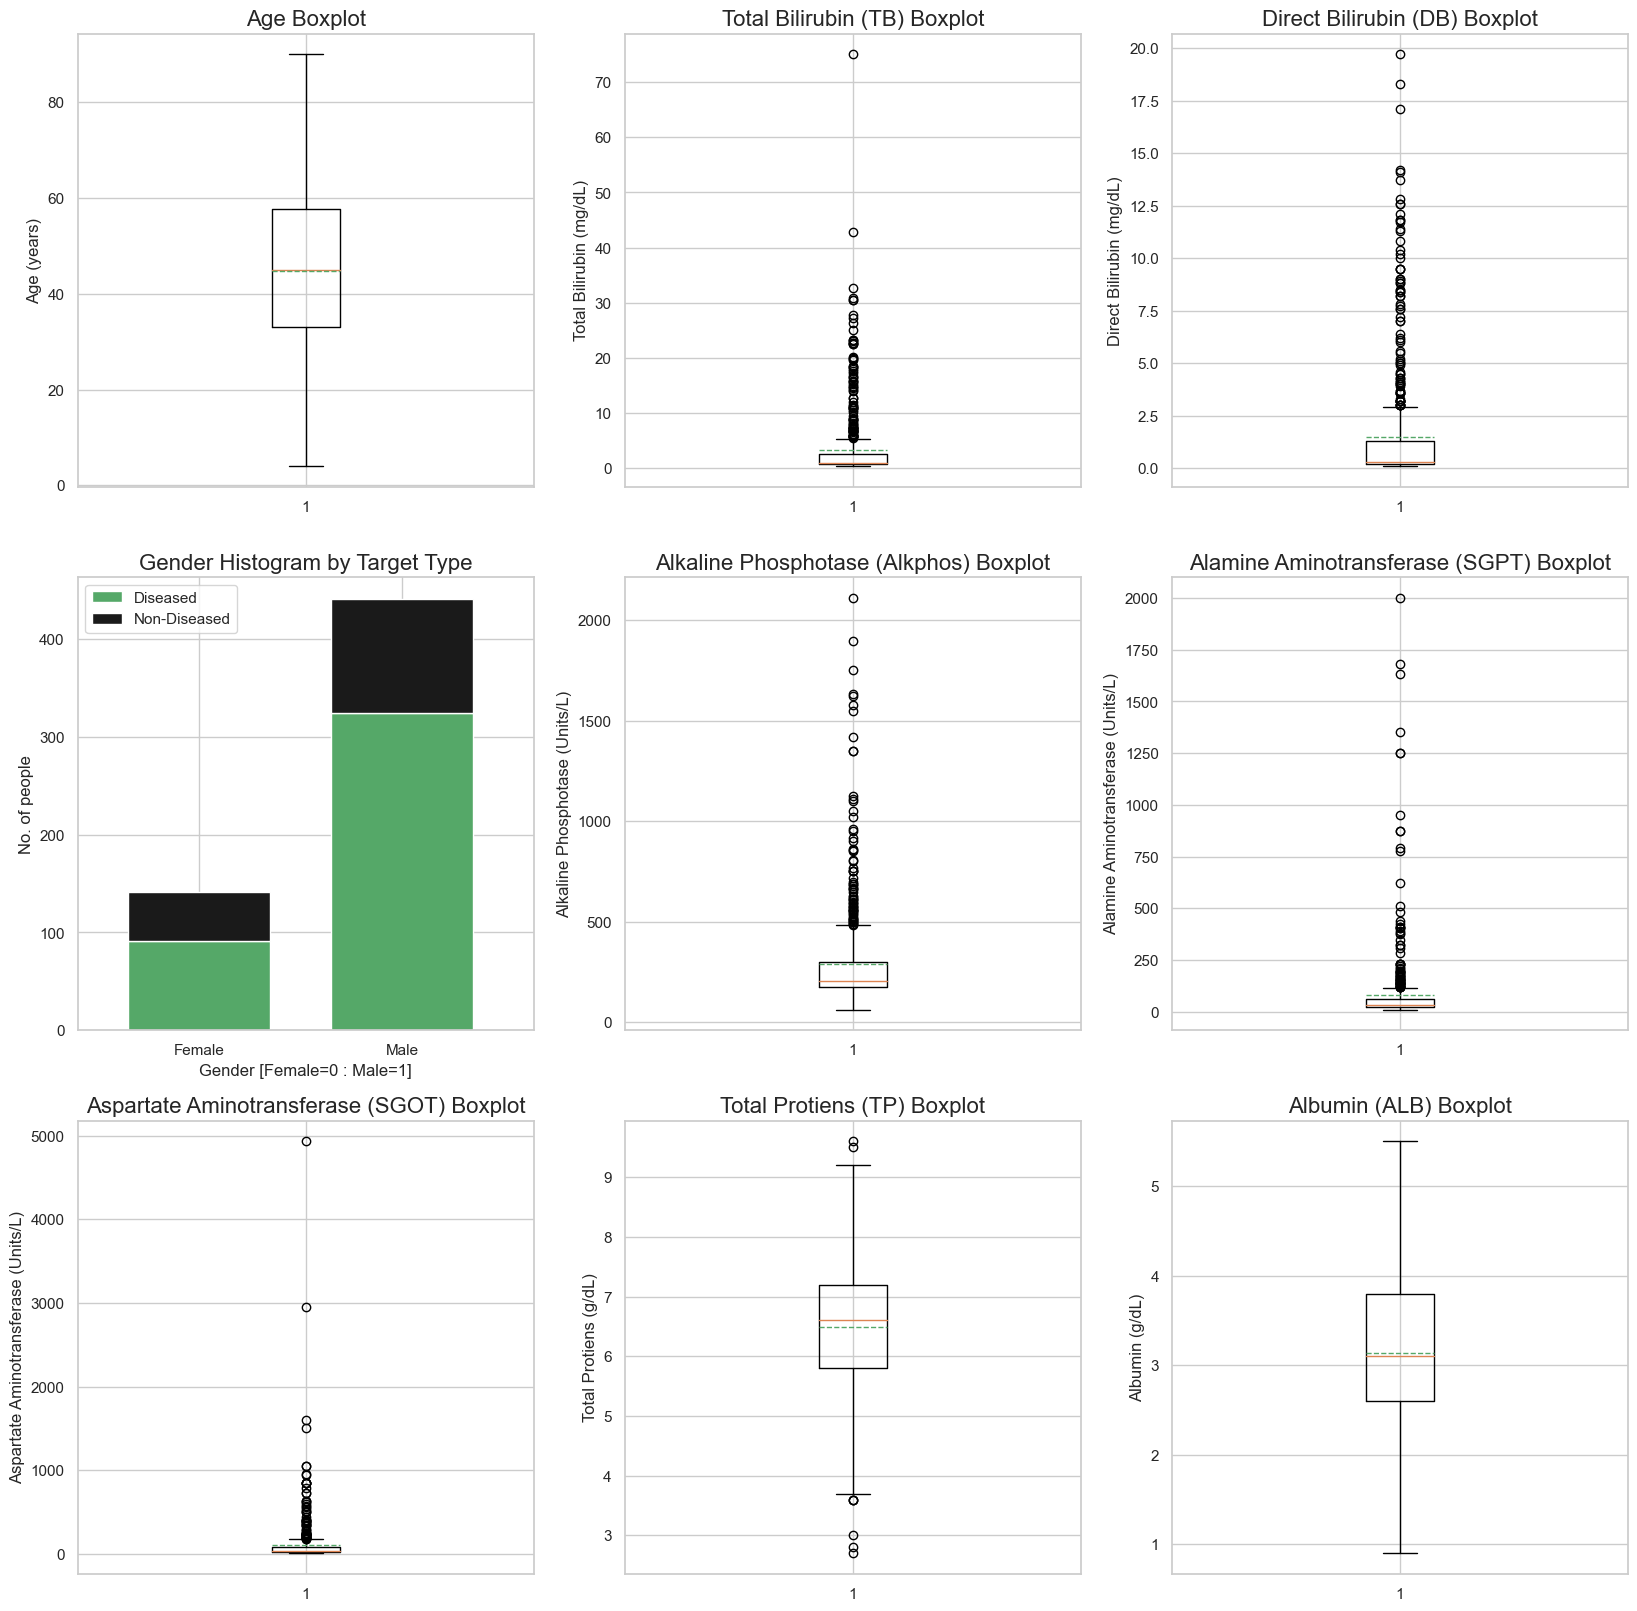

In [27]:
# Plotting the box plots and gender histogram
sns.set_theme(style='whitegrid')
plt.figure(figsize=[20,20])

plt.subplot(3,3,1)
plt.boxplot(x = df['Age'], showmeans=True, meanline=True)
plt.title('Age Boxplot', fontsize=16)
plt.ylabel('Age (years)')

plt.subplot(3,3,2)
plt.boxplot(x=df['Total Bilirubin (TB)'], showmeans=True, meanline=True)
plt.title('Total Bilirubin (TB) Boxplot', fontsize=16)
plt.ylabel('Total Bilirubin (mg/dL)')

plt.subplot(3,3,3)
plt.boxplot(x=df['Direct Bilirubin (DB)'], showmeans=True, meanline=True)
plt.title('Direct Bilirubin (DB) Boxplot', fontsize=16)
plt.ylabel('Direct Bilirubin (mg/dL)')

plt.subplot(3,3,4)
bins = np.arange(3)
width = 0.7
plt.hist(x=[df[df['Target']==1]['Gender'], df[df['Target']==0]['Gender']], stacked=True, color=['g', 'k'], label=['Diseased', 'Non-Diseased'], bins=bins, width=width)
plt.title('Gender Histogram by Target Type', fontsize=16)
plt.xticks(bins[:-1]+0.35, ['Female', 'Male'])
plt.xlim(-0.25,2)
plt.xlabel('Gender [Female=0 : Male=1]')
plt.ylabel('No. of people')
plt.legend()

plt.subplot(3,3,5)
plt.boxplot(x=df['Alkaline Phosphotase (Alkphos)'], showmeans=True, meanline=True)
plt.title('Alkaline Phosphotase (Alkphos) Boxplot', fontsize=16)
plt.ylabel('Alkaline Phosphotase (Units/L)')

plt.subplot(3,3,6)
plt.boxplot(x=df['Alamine Aminotransferase (SGPT)'], showmeans=True, meanline=True)
plt.title('Alamine Aminotransferase (SGPT) Boxplot', fontsize=16)
plt.ylabel('Alamine Aminotransferase (Units/L)')

plt.subplot(3,3,7)
plt.boxplot(x=df['Aspartate Aminotransferase (SGOT)'], showmeans=True, meanline=True)
plt.title('Aspartate Aminotransferase (SGOT) Boxplot', fontsize=16)
plt.ylabel('Aspartate Aminotransferase (Units/L)')

plt.subplot(3,3,8)
plt.boxplot(x=df['Total Protiens (TP)'], showmeans=True, meanline=True)
plt.title('Total Protiens (TP) Boxplot', fontsize=16)
plt.ylabel('Total Protiens (g/dL)')

plt.subplot(3,3,9)
plt.boxplot(x=df['Albumin (ALB)'], showmeans=True, meanline=True)
plt.title('Albumin (ALB) Boxplot', fontsize=16)
plt.ylabel('Albumin (g/dL)')



The boxplots above show many outliers present. But these cannot be ignored as they could be genuine clinical outliers for diseased patients. A person can have high levels of Aspartate Aminotransferase which would indicates that the person has liver problems. We can also see a large disparity between male and female data where we see more male data points than female. This shows that the dataset is biased and may not generalise well to female data which have not been as represented in the dataset as males have.

<Axes: xlabel='Target', ylabel='Total Protiens (TP)'>

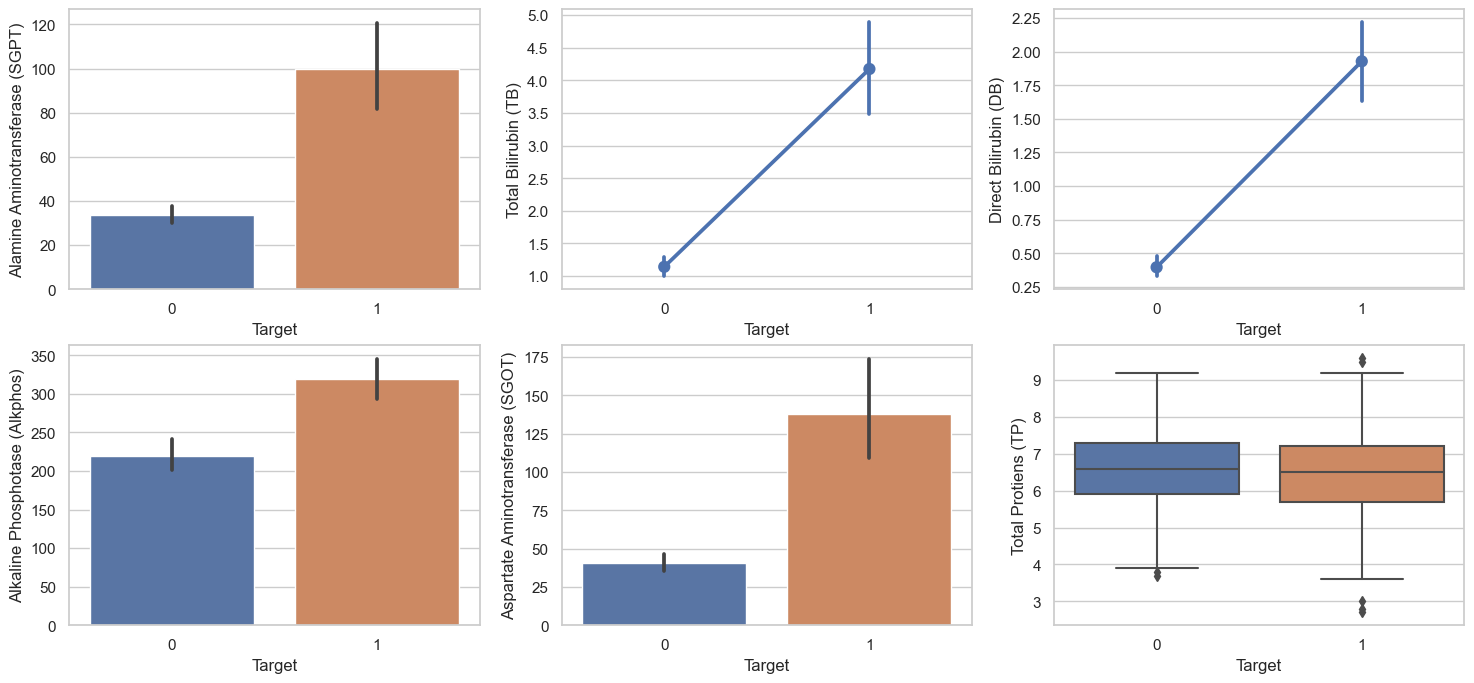

In [28]:
# Plotting the relationship between features and diseased/non-diseased patients
sns.set_theme(style='whitegrid')
fig, saxis = plt.subplots(2, 3,figsize=(18,8))

sns.barplot(y='Alamine Aminotransferase (SGPT)', x='Target', data=df, ax = saxis[0,0])
sns.pointplot(y='Total Bilirubin (TB)', x='Target', data=df, ax = saxis[0,1])
sns.pointplot(y = 'Direct Bilirubin (DB)', x='Target', data=df, ax = saxis[0,2])

sns.barplot(y = 'Alkaline Phosphotase (Alkphos)', x = 'Target', data=df, ax = saxis[1,0])
sns.barplot(y = 'Aspartate Aminotransferase (SGOT)', x = 'Target', data=df, ax = saxis[1,1])
sns.boxplot(y = 'Total Protiens (TP)', x = 'Target', data=df, ax = saxis[1,2])

As demonstrated above, the higher the values of each individual blood test, the more risk you have of having a liver related disease.

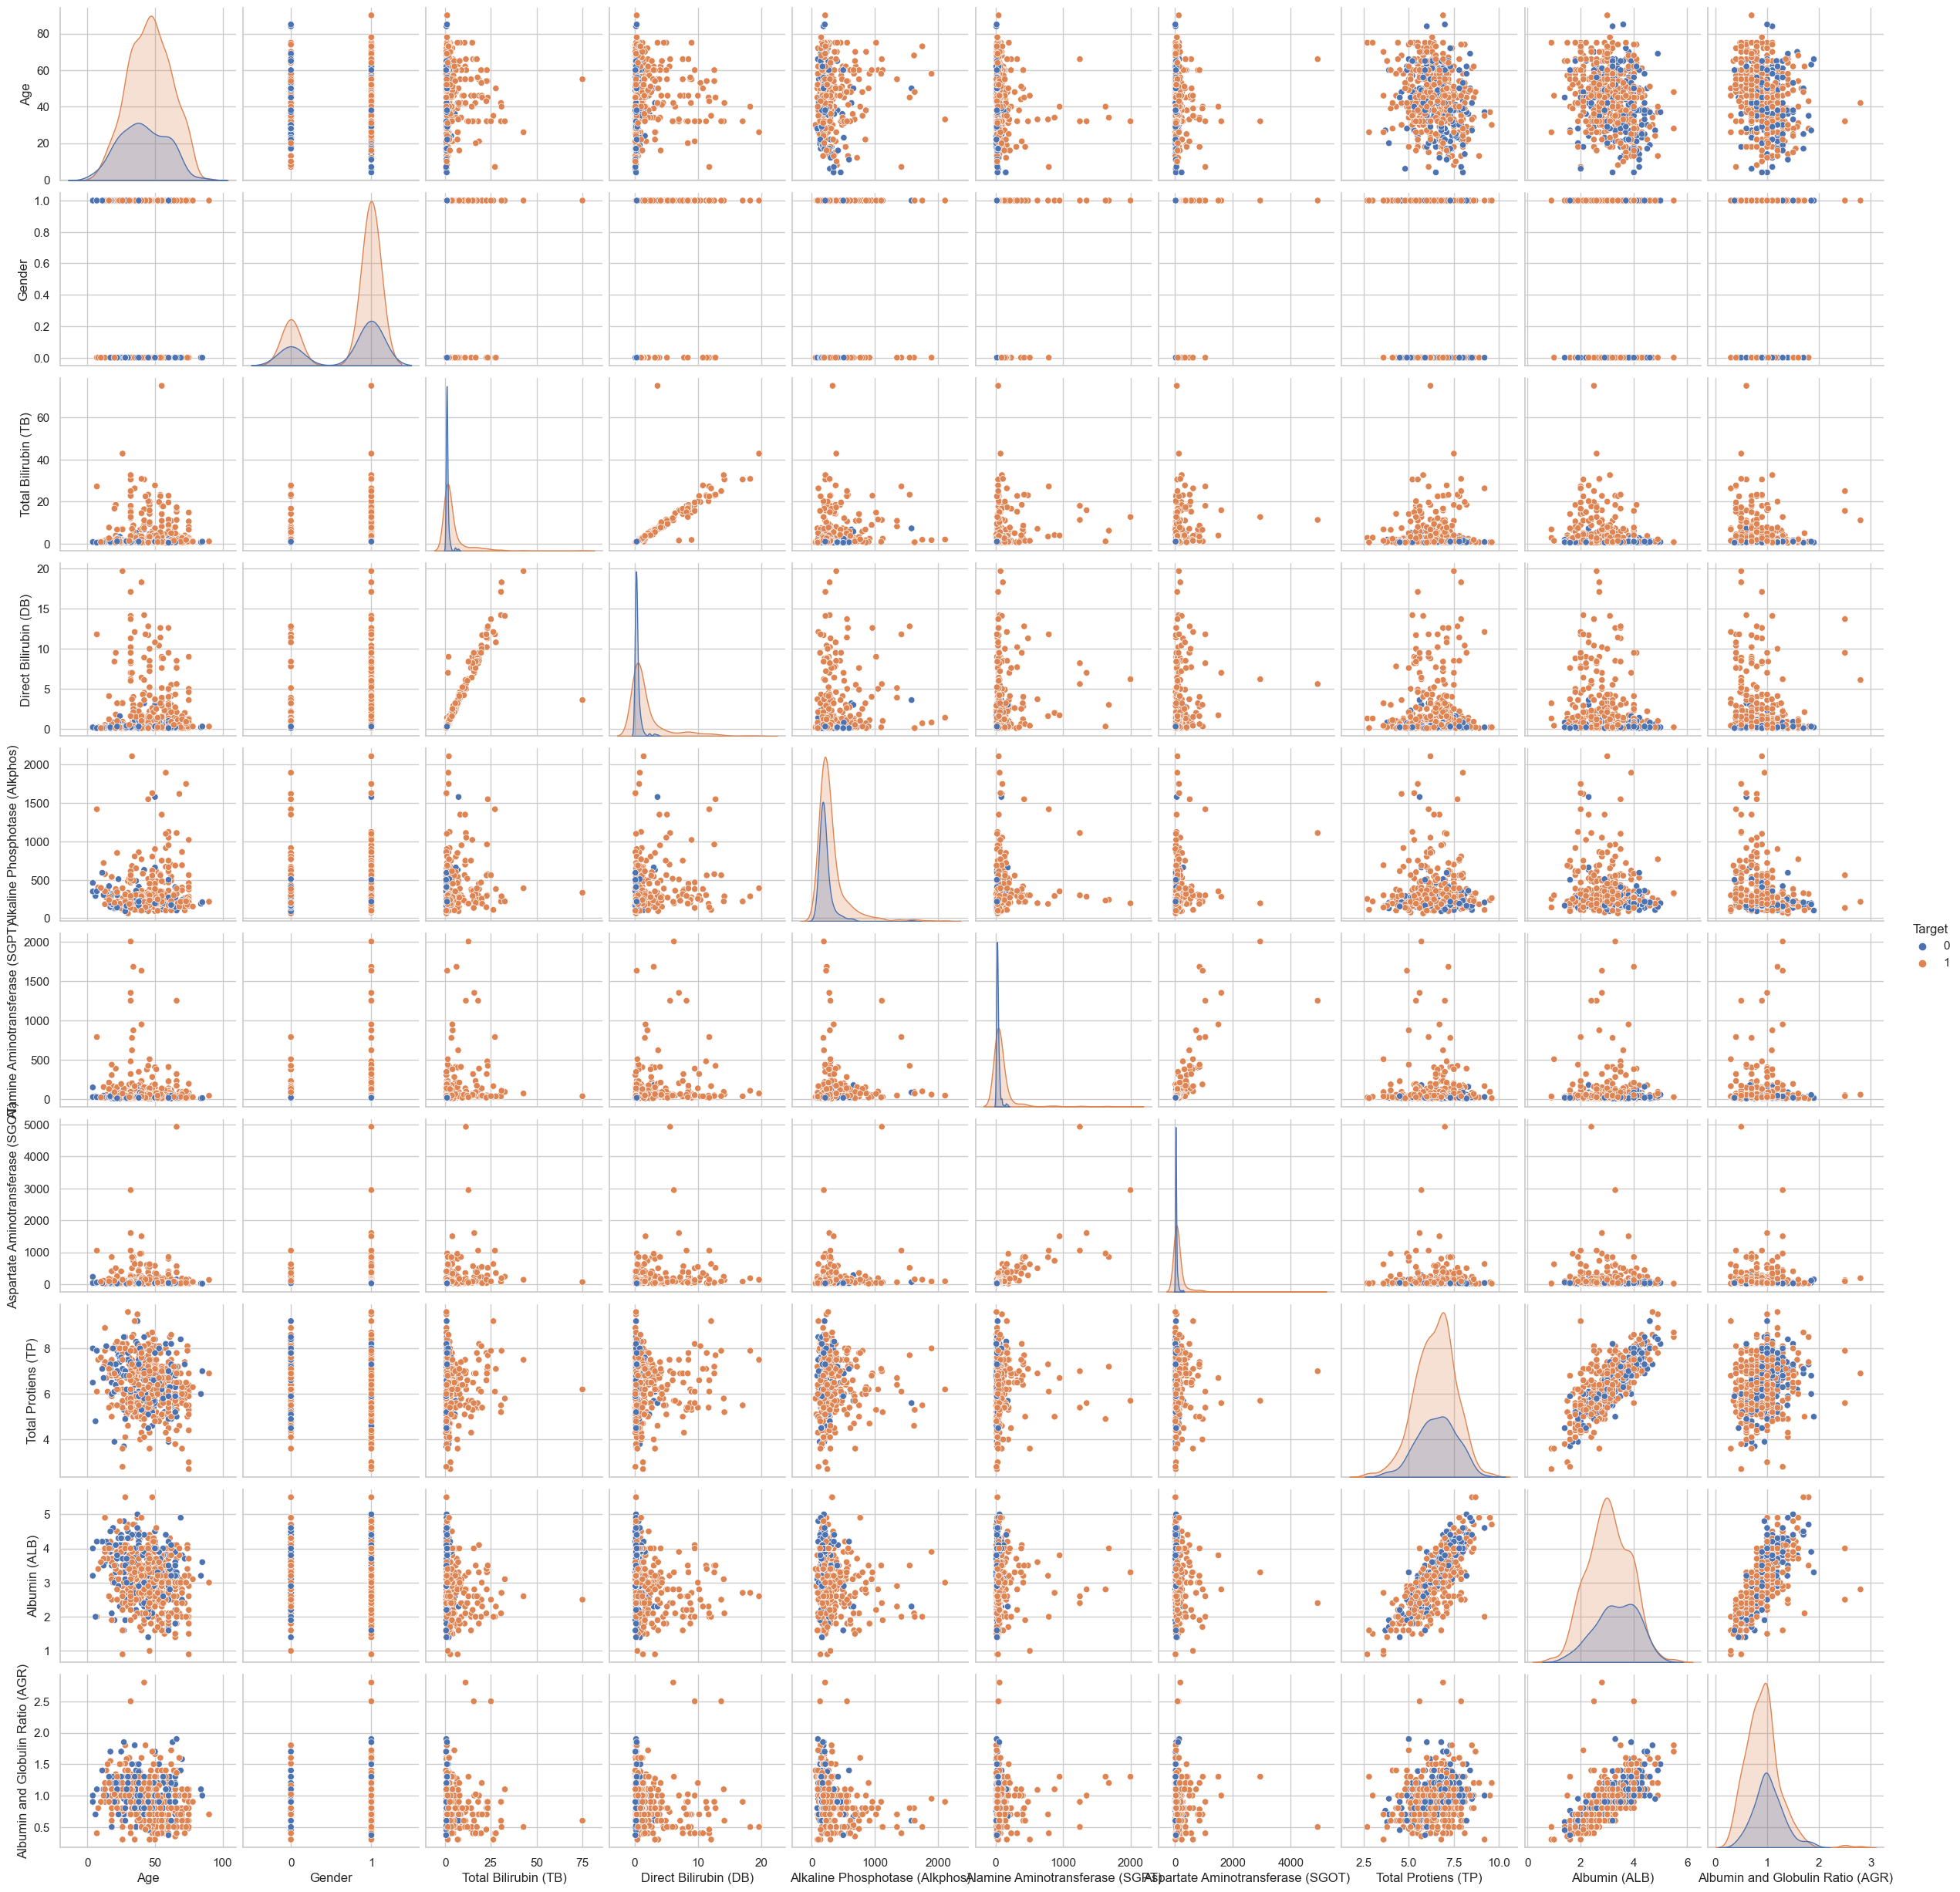

In [29]:
# Plotting pair plot of all features
plt.rcParams['figure.figsize']=(15,15)
sns.pairplot(df,hue='Target')

Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalised. The below shows the numerical variables that are skewed.

Text(0, 0.5, 'N of records')

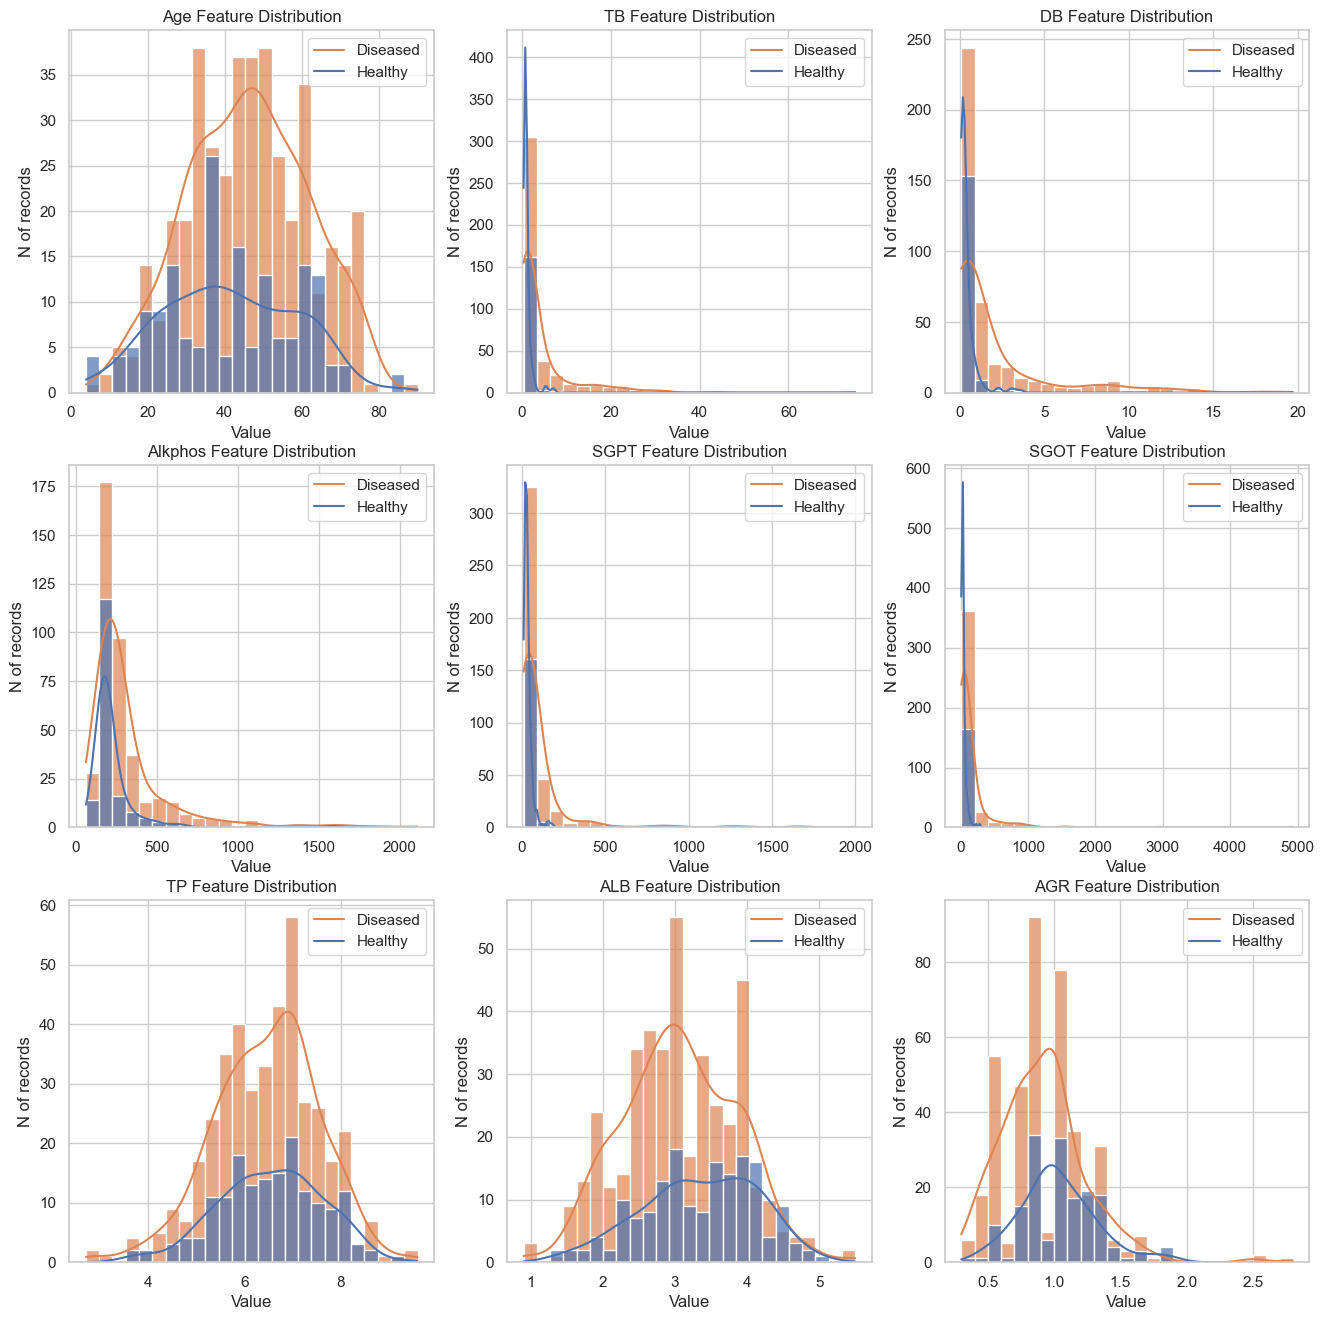

In [30]:
# Create distribution subplots
fig, saxis = plt.subplots(3, 3, figsize=(16, 16))

# Plot Age feature distribution
sns.histplot(df, x='Age', hue='Target', bins=25, ax=saxis[0,0], kde=True, alpha=0.7, palette='deep')
saxis[0,0].set_title('Age Feature Distribution')
saxis[0,0].legend(['Diseased', 'Healthy'])
saxis[0,0].set_xlabel('Value')
saxis[0,0].set_ylabel('N of records')

# Plot Total Bilirubin feature distribution
sns.histplot(df, x='Total Bilirubin (TB)', hue='Target', bins=25, ax=saxis[0,1], kde=True, alpha=0.7, palette='deep')
saxis[0,1].set_title('TB Feature Distribution')
saxis[0,1].legend(['Diseased', 'Healthy'])
saxis[0,1].set_xlabel('Value')
saxis[0,1].set_ylabel('N of records')

# Plot Direct Bilirubin feature distribution
sns.histplot(df, x='Direct Bilirubin (DB)', hue='Target', bins=25, ax=saxis[0,2], kde=True, alpha=0.7, palette='deep')
saxis[0,2].set_title('DB Feature Distribution')
saxis[0,2].legend(['Diseased', 'Healthy'])
saxis[0,2].set_xlabel('Value')
saxis[0,2].set_ylabel('N of records')

# Plot Alkaline Phosphotase feature distribution
sns.histplot(df, x='Alkaline Phosphotase (Alkphos)', hue='Target', bins=25, ax=saxis[1,0], kde=True, alpha=0.7, palette='deep')
saxis[1,0].set_title('Alkphos Feature Distribution')
saxis[1,0].legend(['Diseased', 'Healthy'])
saxis[1,0].set_xlabel('Value')
saxis[1,0].set_ylabel('N of records')

# Plot Alamine Aminotransferase feature distribution
sns.histplot(df, x='Alamine Aminotransferase (SGPT)', hue='Target', bins=25, ax=saxis[1,1], kde=True, alpha=0.7, palette='deep')
saxis[1,1].set_title('SGPT Feature Distribution')
saxis[1,1].legend(['Diseased', 'Healthy'])
saxis[1,1].set_xlabel('Value')
saxis[1,1].set_ylabel('N of records')

# Plot Aspartate Aminotransferase  feature distribution
sns.histplot(df, x='Aspartate Aminotransferase (SGOT)', hue='Target', bins=25, ax=saxis[1,2], kde=True, alpha=0.7, palette='deep')
saxis[1,2].set_title('SGOT Feature Distribution')
saxis[1,2].legend(['Diseased', 'Healthy'])
saxis[1,2].set_xlabel('Value')
saxis[1,2].set_ylabel('N of records')

# Plot Total Protiens feature distribution
sns.histplot(df, x='Total Protiens (TP)', hue='Target', bins=25, ax=saxis[2,0], kde=True, alpha=0.7, palette='deep')
saxis[2,0].set_title('TP Feature Distribution')
saxis[2,0].legend(['Diseased', 'Healthy'])
saxis[2,0].set_xlabel('Value')
saxis[2,0].set_ylabel('N of records')

# Plot Albumin feature distribution
sns.histplot(df, x='Albumin (ALB)', hue='Target', bins=25, ax=saxis[2,1], kde=True, alpha=0.7, palette='deep')
saxis[2,1].set_title('ALB Feature Distribution')
saxis[2,1].legend(['Diseased', 'Healthy'])
saxis[2,1].set_xlabel('Value')
saxis[2,1].set_ylabel('N of records')

# Plot Albumin and Globulin Ratio feature distribution
sns.histplot(df, x='Albumin and Globulin Ratio (AGR)', hue='Target', bins=25, ax=saxis[2,2], kde=True, alpha=0.7, palette='deep')
saxis[2,2].set_title('AGR Feature Distribution')
saxis[2,2].legend(['Diseased', 'Healthy'])
saxis[2,2].set_xlabel('Value')
saxis[2,2].set_ylabel('N of records')


From the above plot the following interpretations were made:

* __Age__: Liver disease was predominately found for patients above the age of 20, potentially due to drinking habits.
* __TB__: TB levels of <=10 are seen for non-diseased patients and for diseased patients this ranged from 0-70. A higher TB level is associated with liver disease.
* __DB__: Similiar relationship with the target variable is seen for DB where non diseased patients have low DB levels and diseased patients have higher DB levels.
* __Alkphos__: Liver disease/damage is seen for high levels of Alkphos
* __SGPT__: Patients with liver disease have high values of SGPT (>250) and those patients with lower values do not
* __SGOT__: Similarly to SGPT, high values of SGOT are assoicated with liver damage or disease compared to patients with low values of SGOT
* __TP__, __ALB__, __AGR__ : The data follows the same distribution regardless of target variable however these features will be maintained in the model.

In [31]:
# Save the plot as an image
fig.savefig('distributions-by-target.png')

Before normalising these features, a couple features will be constructed first and their distribution will be checked to see whether they need to be normalised as well. If they are to be normalised they will be included in the normalisation loop for skewed features below, otherwise they will be left out.

### Feature Construction

In [32]:
# Saving original dataframe
df_save = df.copy()

# AST-ALT ratio
df['AST-ALT Ratio'] = df['Aspartate Aminotransferase (SGOT)'] / df['Alamine Aminotransferase (SGPT)']

# R factor
df['R Ratio'] = (df['Alamine Aminotransferase (SGPT)'] / 40) / (df['Alkaline Phosphotase (Alkphos)'] / 120) 

Text(0, 0.5, 'N of records')

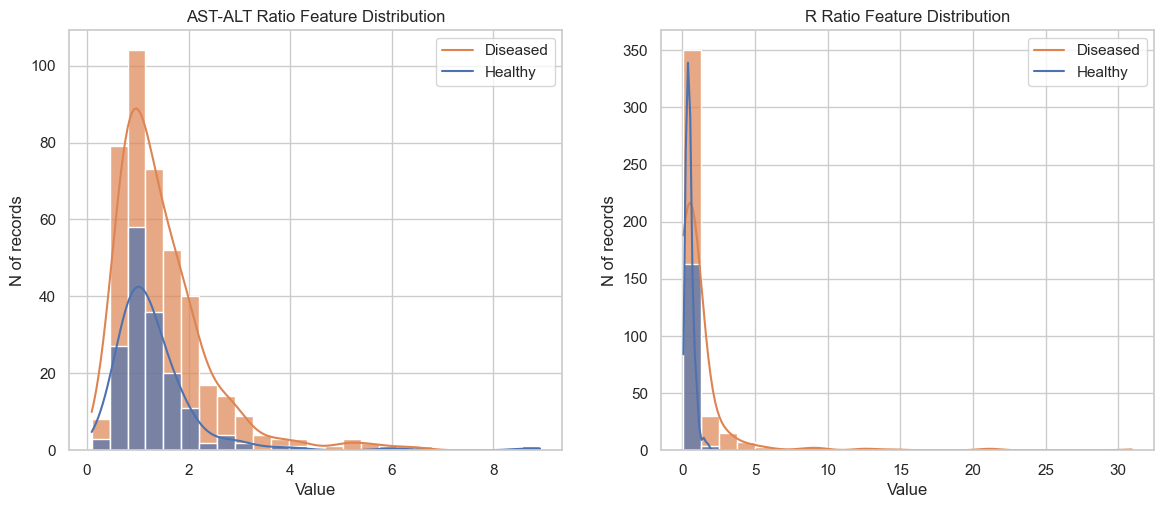

In [33]:
fig = plt.subplots(figsize=(14, 12))

# Plot AST-ALT Ratio feature distribution
sub1 = plt.subplot(2,2,1)
sns.histplot(df, x='AST-ALT Ratio', hue='Target', bins=25, kde=True, alpha=0.7, palette='deep')
sub1.set_title('AST-ALT Ratio Feature Distribution')
sub1.legend(['Diseased', 'Healthy'])
sub1.set_xlabel('Value')
sub1.set_ylabel('N of records')

# Plot R Ratio feature distribution
sub2 = plt.subplot(2,2,2)
sns.histplot(df, x='R Ratio', hue='Target', bins=25, kde=True, alpha=0.7, palette='deep')
sub2.set_title('R Ratio Feature Distribution')
sub2.legend(['Diseased', 'Healthy'])
sub2.set_xlabel('Value')
sub2.set_ylabel('N of records')

In [34]:
# Arranging columns
cols = ['Age', 'Gender', 'Total Bilirubin (TB)', 'Direct Bilirubin (DB)', 'Alkaline Phosphotase (Alkphos)', 
           'Alamine Aminotransferase (SGPT)', 'Aspartate Aminotransferase (SGOT)', 'Total Protiens (TP)', 
           'Albumin (ALB)', 'Albumin and Globulin Ratio (AGR)', 'AST-ALT Ratio', 'R Ratio', 'Target']

df = df[cols]

In [35]:
df.head()

,Age,Gender,Total Bilirubin (TB),Direct Bilirubin (DB),Alkaline Phosphotase (Alkphos),Alamine Aminotransferase (SGPT),Aspartate Aminotransferase (SGOT),Total Protiens (TP),Albumin (ALB),Albumin and Globulin Ratio (AGR),AST-ALT Ratio,R Ratio,Target
0,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1.562500,0.274678,1
1,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1.133333,0.367347,1
2,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1.428571,0.230769,1
3,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,2.185185,0.415385,1
4,46,1,1.8,0.7,208,19,14,7.6,4.4,1.30,0.736842,0.274038,1


### Skewness

One option to deal with skewed features is to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Care must be taken when applying this transformation however: The logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the the logarithm successfully.

In [36]:
# List of skewed features
skewed = ['Total Bilirubin (TB)', 'Direct Bilirubin (DB)', 'Alkaline Phosphotase (Alkphos)', 
           'Alamine Aminotransferase (SGPT)', 'Aspartate Aminotransferase (SGOT)', 
           'Total Protiens (TP)', 'Albumin and Globulin Ratio (AGR)','AST-ALT Ratio', 'R Ratio']

# Apply log transformation on skewed features
for column in skewed:
    df[column] = df[column].apply(lambda x: np.log(x+1))


Text(0, 0.5, 'N of records')

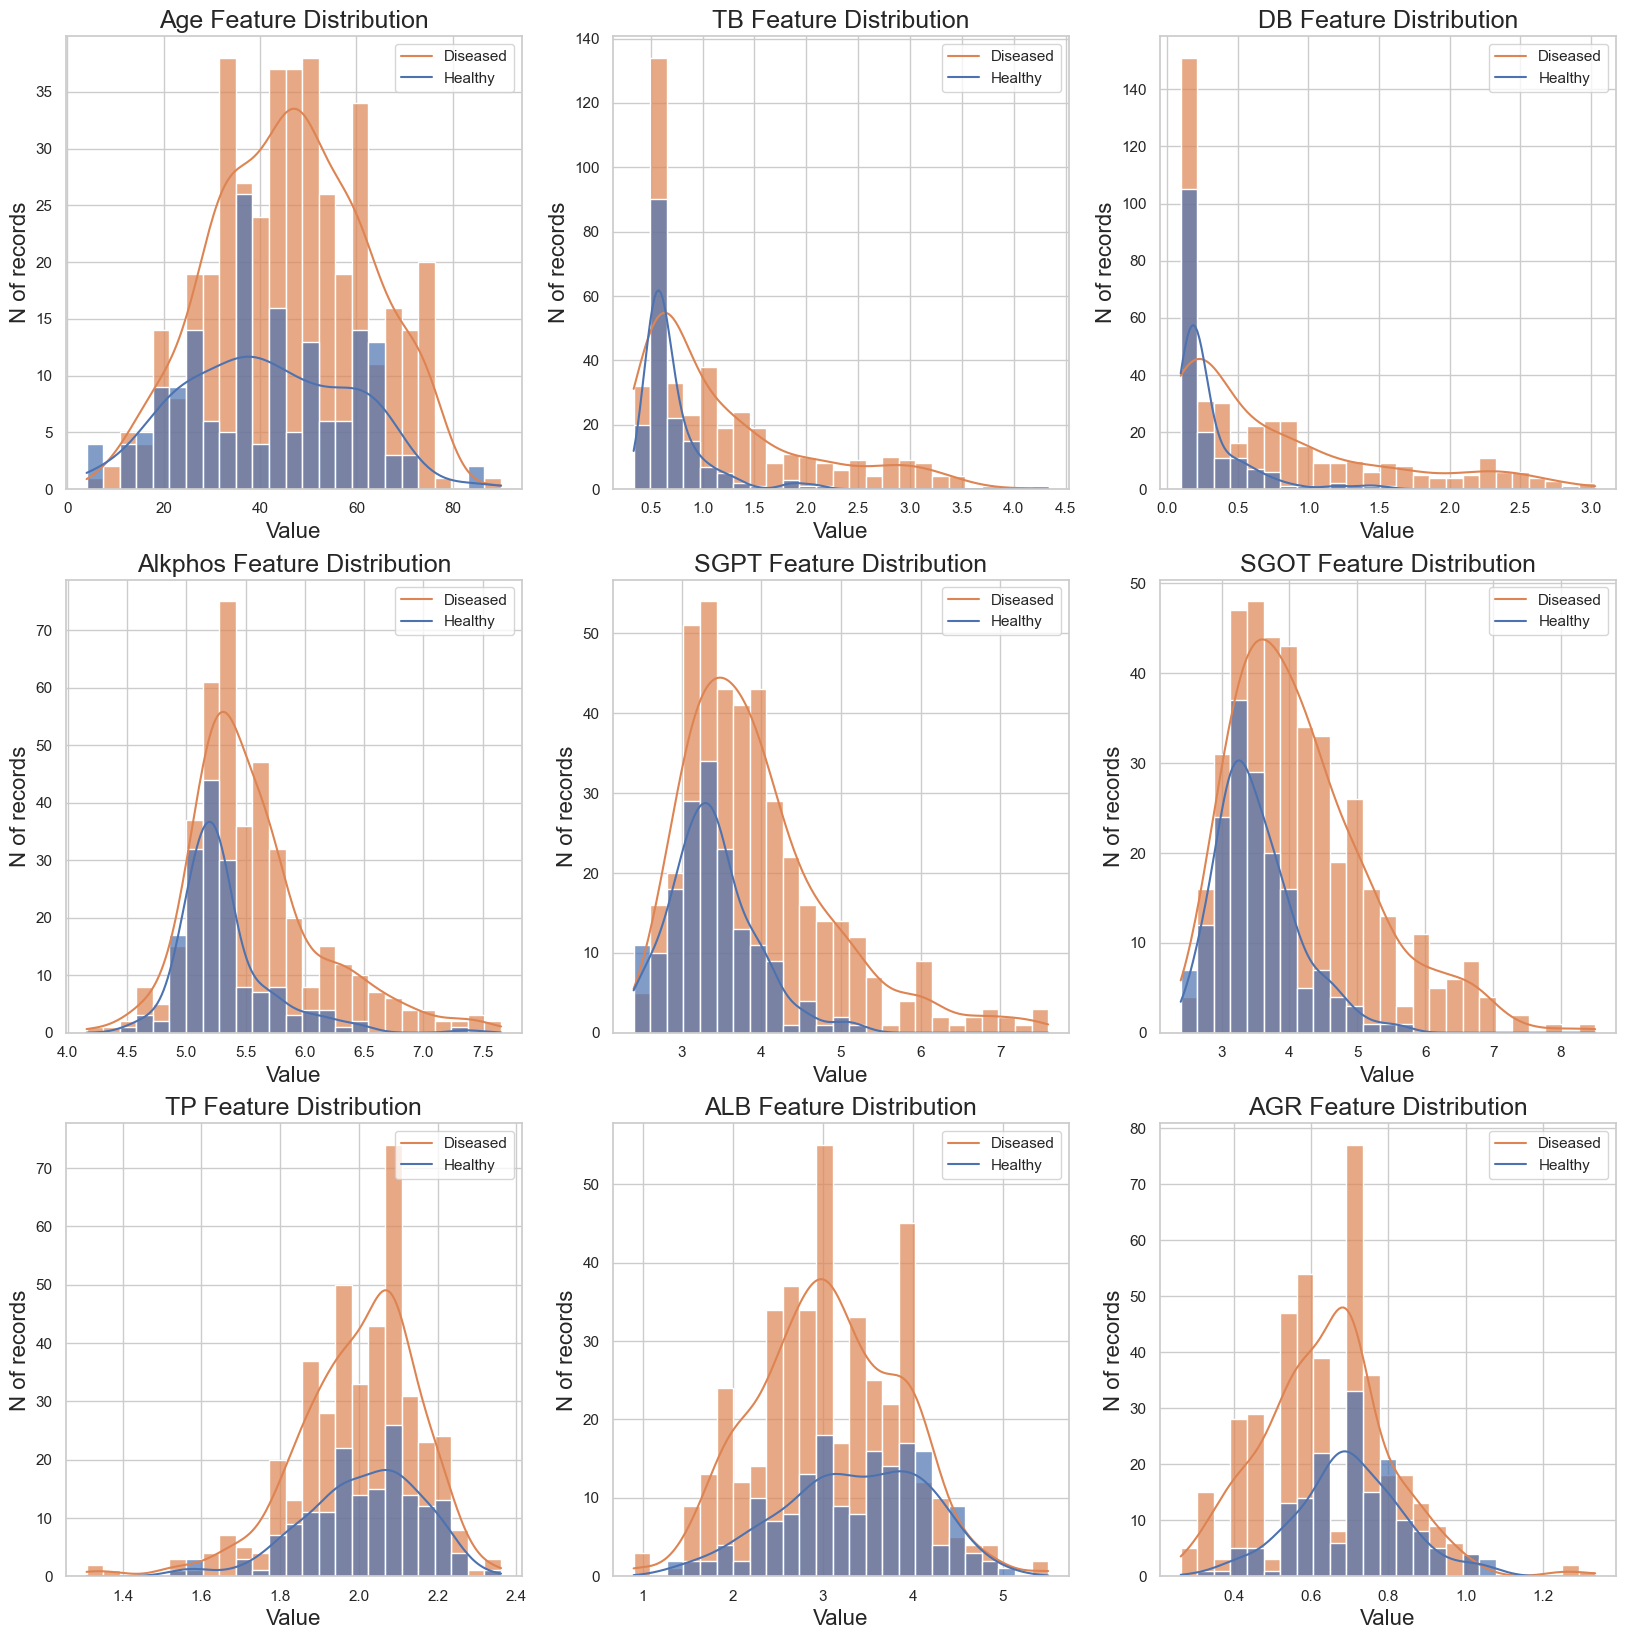

In [37]:
# Create distribution sub plots for original features
fig, saxis = plt.subplots(3, 3, figsize=(20, 20))

# Plot Age feature distribution
sns.histplot(df, x='Age', hue='Target', bins=25, ax=saxis[0,0], kde=True, alpha=0.7, palette='deep')
saxis[0,0].set_title('Age Feature Distribution', fontsize=18)
saxis[0,0].legend(['Diseased', 'Healthy'], fontsize=11, loc='upper right')
saxis[0,0].set_xlabel('Value', fontsize=16)
saxis[0,0].set_ylabel('N of records', fontsize=16)

# Plot Total Bilirubin feature distribution
sns.histplot(df, x='Total Bilirubin (TB)', hue='Target', bins=25, ax=saxis[0,1], kde=True, alpha=0.7, palette='deep')
saxis[0,1].set_title('TB Feature Distribution', fontsize=18)
saxis[0,1].legend(['Diseased', 'Healthy'], fontsize=11, loc='upper right')
saxis[0,1].set_xlabel('Value', fontsize=16)
saxis[0,1].set_ylabel('N of records', fontsize=16)

# Plot Direct Bilirubin feature distribution
sns.histplot(df, x='Direct Bilirubin (DB)', hue='Target', bins=25, ax=saxis[0,2], kde=True, alpha=0.7, palette='deep')
saxis[0,2].set_title('DB Feature Distribution', fontsize=18)
saxis[0,2].legend(['Diseased', 'Healthy'], fontsize=11, loc='upper right')
saxis[0,2].set_xlabel('Value', fontsize=16)
saxis[0,2].set_ylabel('N of records', fontsize=16)

# Plot Alkaline Phosphotase feature distribution
sns.histplot(df, x='Alkaline Phosphotase (Alkphos)', hue='Target', bins=25, ax=saxis[1,0], kde=True, alpha=0.7, palette='deep')
saxis[1,0].set_title('Alkphos Feature Distribution', fontsize=18)
saxis[1,0].legend(['Diseased', 'Healthy'], fontsize=11, loc='upper right')
saxis[1,0].set_xlabel('Value', fontsize=16)
saxis[1,0].set_ylabel('N of records', fontsize=16)

# Plot Alamine Aminotransferase feature distribution
sns.histplot(df, x='Alamine Aminotransferase (SGPT)', hue='Target', bins=25, ax=saxis[1,1], kde=True, alpha=0.7, palette='deep')
saxis[1,1].set_title('SGPT Feature Distribution', fontsize=18)
saxis[1,1].legend(['Diseased', 'Healthy'], fontsize=11, loc='upper right')
saxis[1,1].set_xlabel('Value', fontsize=16)
saxis[1,1].set_ylabel('N of records', fontsize=16)

# Plot Aspartate Aminotransferase  feature distribution
sns.histplot(df, x='Aspartate Aminotransferase (SGOT)', hue='Target', bins=25, ax=saxis[1,2], kde=True, alpha=0.7, palette='deep')
saxis[1,2].set_title('SGOT Feature Distribution', fontsize=18)
saxis[1,2].legend(['Diseased', 'Healthy'], fontsize=11, loc='upper right')
saxis[1,2].set_xlabel('Value', fontsize=16)
saxis[1,2].set_ylabel('N of records', fontsize=16)

# Plot Total Protiens feature distribution
sns.histplot(df, x='Total Protiens (TP)', hue='Target', bins=25, ax=saxis[2,0], kde=True, alpha=0.7, palette='deep')
saxis[2,0].set_title('TP Feature Distribution', fontsize=18)
saxis[2,0].legend(['Diseased', 'Healthy'], fontsize=11, loc='upper right')
saxis[2,0].set_xlabel('Value', fontsize=16)
saxis[2,0].set_ylabel('N of records', fontsize=16)

# Plot Albumin feature distribution
sns.histplot(df, x='Albumin (ALB)', hue='Target', bins=25, ax=saxis[2,1], kde=True, alpha=0.7, palette='deep')
saxis[2,1].set_title('ALB Feature Distribution', fontsize=18)
saxis[2,1].legend(['Diseased', 'Healthy'], fontsize=11, loc='upper right')
saxis[2,1].set_xlabel('Value', fontsize=16)
saxis[2,1].set_ylabel('N of records', fontsize=16)

# Plot Albumin and Globulin Ratio feature distribution
sns.histplot(df, x='Albumin and Globulin Ratio (AGR)', hue='Target', bins=25, ax=saxis[2,2],  kde=True, alpha=0.7, palette='deep')
saxis[2,2].set_title('AGR Feature Distribution', fontsize=18)
saxis[2,2].legend(['Diseased', 'Healthy'], fontsize=11, loc='upper right')
saxis[2,2].set_xlabel('Value', fontsize=16)
saxis[2,2].set_ylabel('N of records', fontsize=16)

In [38]:
# Save distribution plots
fig.savefig('skewed-distributions-by-target.png')

### Scaling

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution.

In [39]:
# Initialize the scaler, then apply it to the dataset
Scaler = MinMaxScaler()
Scaler.fit_transform(df[['Total Bilirubin (TB)', 'Direct Bilirubin (DB)', 'Alkaline Phosphotase (Alkphos)', 
           'Alamine Aminotransferase (SGPT)', 'Aspartate Aminotransferase (SGOT)', 'Total Protiens (TP)', 
           'Albumin (ALB)', 'Albumin and Globulin Ratio (AGR)', 'AST-ALT Ratio', 'R Ratio','Target']])


array([[0.53578524, 0.60531476, 0.6842603 , ..., 0.38703358, 0.05201903,
        1.        ],
       [0.44558511, 0.52266528, 0.58282072, ..., 0.30404593, 0.07267487,
        1.        ],
       [0.08929685, 0.08217259, 0.30051283, ..., 0.36273   , 0.04170141,
        1.        ],
       ...,
       [0.06291888, 0.02964791, 0.38513598, ..., 0.27951797, 0.11666249,
        1.        ],
       [0.12428754, 0.10568095, 0.30362198, ..., 0.29765871, 0.09454693,
        1.        ],
       [0.08929685, 0.05692134, 0.34925698, ..., 0.30606263, 0.0559159 ,
        0.        ]])

### Feature Selection

Sequential Feature Selector library will be utilised to select the best features to optimise the model on. Box plots will be used to show the effect of backward selecting features in a backwards manner on performance using cross validation with stratified K-folds in our dataset for each algorithm: SVM & Random Forest. This output will show how many features each algorithm needs to create the best performing model.

#### Feature Engineered Dataset

In [40]:
# Initialise estimators
svm = SVC(probability=True, random_state=0)
rf = RandomForestClassifier(random_state=0)

# Define dataset for feature selection 
X_sfs = df.iloc[:, :-1]
y_sfs = df.iloc[:, -1]

In [41]:
# Define range of number of features
num_features = range(1, len(X_sfs.columns))

# Create models on each subset of features
def get_models(clf, num_features):
    models = dict()
    for i in num_features:
        sfs = SequentialFeatureSelector(clf, n_features_to_select=int(i), direction='backward', n_jobs=-1)
        model = clf
        models[str(i)] = Pipeline(steps=[('s', sfs), ('m', model)])
    return models

# Evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores

In [42]:
# Get the models to evaluate
rf_models = get_models(rf, num_features)
svm_models = get_models(svm, num_features)

In [43]:
# Store results with mean and std
def store_results(models, X, y):
    results, names = list(), list()
    for name, model in models.items():
        scores = evaluate_model(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    return results, names

In [44]:
# Generate results for each classifier
print('Random Forest Classifier scores:')
results_rf, names_rf = store_results(rf_models, X_sfs, y_sfs)
print('SVM scores:')
results_svm, names_svm = store_results(svm_models, X_sfs, y_sfs)

Random Forest Classifier scores:
>1 0.603 (0.068)
>2 0.630 (0.076)
>3 0.680 (0.067)
>4 0.715 (0.066)
>5 0.724 (0.069)
>6 0.733 (0.064)
>7 0.738 (0.054)
>8 0.743 (0.054)
>9 0.737 (0.049)
>10 0.740 (0.054)
>11 0.741 (0.055)
SVM scores:
>1 0.510 (0.074)
>2 0.579 (0.096)
>3 0.577 (0.076)
>4 0.622 (0.073)
>5 0.630 (0.067)
>6 0.688 (0.056)
>7 0.680 (0.067)
>8 0.672 (0.066)
>9 0.683 (0.067)
>10 0.677 (0.064)
>11 0.666 (0.072)


#### Original Dataframe

In [45]:
# Copying original saved dataframe
df = df_save.copy()

# Apply skewness
# List of skewed features
skewed = ['Total Bilirubin (TB)', 'Direct Bilirubin (DB)', 'Alkaline Phosphotase (Alkphos)', 
           'Alamine Aminotransferase (SGPT)', 'Aspartate Aminotransferase (SGOT)', 
           'Total Protiens (TP)', 'Albumin and Globulin Ratio (AGR)']

# Apply log transformation on skewed features
for column in skewed:
    df[column] = df[column].apply(lambda x: np.log(x+1))

# Scale dataset
Scaler = MinMaxScaler()
Scaler.fit_transform(df[['Total Bilirubin (TB)', 'Direct Bilirubin (DB)', 'Alkaline Phosphotase (Alkphos)', 
           'Alamine Aminotransferase (SGPT)', 'Aspartate Aminotransferase (SGOT)', 'Total Protiens (TP)', 
           'Albumin (ALB)', 'Albumin and Globulin Ratio (AGR)','Target']])

# Initialise estimators
svm = SVC(probability=True, random_state=0)
rf = RandomForestClassifier(random_state=0)

# Define dataset for feature selection 
X_sfs = df.iloc[:, :-1]
y_sfs = df.iloc[:, -1]

# Define range of number of features
num_features = range(1, len(X_sfs.columns))

# Get the models to evaluate
rf_models = get_models(rf, num_features)
svm_models = get_models(svm, num_features)



In [46]:
# Generate results for each classifier
print('Random Forest Classifier scores:')
results_rf, names_rf = store_results(rf_models, X_sfs, y_sfs)
print('SVM scores:')
results_svm, names_svm = store_results(svm_models, X_sfs, y_sfs)

Random Forest Classifier scores:
>1 0.614 (0.089)
>2 0.639 (0.089)
>3 0.681 (0.081)
>4 0.706 (0.072)
>5 0.723 (0.061)
>6 0.730 (0.055)
>7 0.734 (0.057)
>8 0.755 (0.044)
>9 0.746 (0.055)
SVM scores:
>1 0.557 (0.089)
>2 0.466 (0.079)
>3 0.492 (0.055)
>4 0.637 (0.051)
>5 0.672 (0.067)
>6 0.670 (0.069)
>7 0.679 (0.063)
>8 0.679 (0.062)
>9 0.663 (0.073)


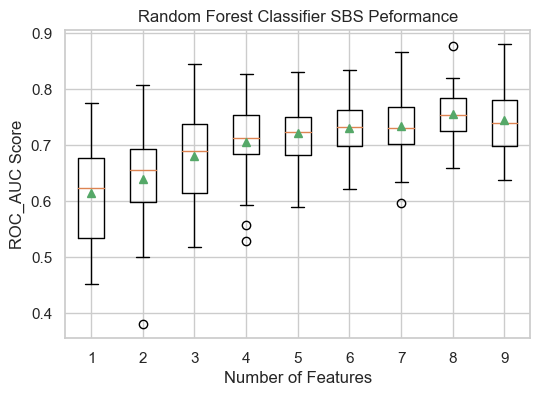

In [47]:
# Plot Random Forest Classifier performance for each feature subset
sns.set_theme(style='whitegrid')
fig =plt.figure(figsize=[6,4])

plt.boxplot(results_rf, labels=names_rf, showmeans=True)
plt.title('Random Forest Classifier SBS Peformance')
plt.xlabel('Number of Features')
plt.ylabel('ROC_AUC Score')
plt.show()

In [48]:
# Save boxplot figure for Random Forest
fig.savefig('RF-feature-selection.png')

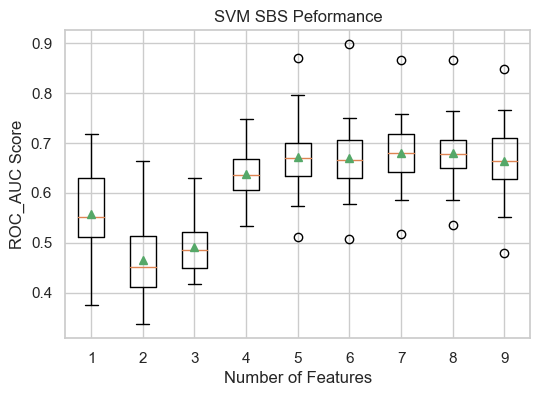

In [49]:
# Plot SVM performance for each feature subset
sns.set_theme(style='whitegrid')
fig = plt.figure(figsize=[6,4])

plt.boxplot(results_svm, labels=names_svm, showmeans=True)
plt.title('SVM SBS Peformance')
plt.xlabel('Number of Features')
plt.ylabel('ROC_AUC Score')
plt.show()

In [50]:
# save boxplot figure for SVM
fig.savefig('SVM-feature-selection.png')

Overall, the most performant model is seen when using the original dataset instead of the feature constructed dataset, therefore this will be maintained during modelling to make a consistent performance comparison between each classifier for the same feature selection algorithm which utlilises the same list of features without compromising overall classification performance.

### Oversampling

This dataset is imbalanced as it contains more "diseased" targets than "non-diseased" targets. To rectify this, oversampling imblearn library SMOTE will be utilised which will generate synthetic data in the minority class (non-diseased) for the training set only to avoid data leakage in the test set.

In [51]:
# Split dataset into features and target
X = df.iloc[:, :-1]
y = target = df.iloc[:, -1]

# Split dataset set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Address class imbalance by SMOTE oversampling
oversample = SMOTE(random_state=0)
features_over, target_over = oversample.fit_resample(X_train, y_train)

# Create new oversampled dataframe
df_balanced = features_over
df_balanced['Target'] = target_over
df_balanced

,Age,Gender,Total Bilirubin (TB),Direct Bilirubin (DB),Alkaline Phosphotase (Alkphos),Alamine Aminotransferase (SGPT),Aspartate Aminotransferase (SGOT),Total Protiens (TP),Albumin (ALB),Albumin and Globulin Ratio (AGR),Target
0,42,1,3.449988,2.721295,5.655992,4.189655,4.875197,1.824549,2.100000,0.470004,1
1,53,0,0.530628,0.095310,5.209486,3.044522,3.526361,1.757858,1.900000,0.470004,1
2,21,0,0.470004,0.095310,5.231109,3.258097,3.135494,2.054124,3.400000,0.693147,1
3,64,0,0.587787,0.182322,5.187386,2.890372,2.944439,1.987874,3.100000,0.641854,1
4,48,1,0.875469,0.470004,5.575949,3.663562,4.204693,1.916923,2.200000,0.476234,1
...,...,...,...,...,...,...,...,...,...,...,...
659,21,1,0.595563,0.193834,5.211775,3.442663,3.921015,2.052268,3.528766,0.706856,0
660,45,0,0.726949,0.369160,5.089586,3.850906,3.761200,1.823159,2.394839,0.606739,0
661,41,0,0.641854,0.182322,5.124827,3.209376,3.154902,2.094271,3.645087,0.665489,0
662,20,0,0.489748,0.182322,5.327334,2.611555,2.814600,2.010954,3.358253,0.689600,0


In [52]:
# Print before and after class oversampling
df_unbalanced = X_train
df_unbalanced['Target'] = y_train

# Print class counts before oversampling
print("Class counts before oversampling")
print(df_unbalanced.groupby(['Target']).size())

# Print class counts after oversampling
print("Class counts after oversampling")
print(df_balanced.groupby(['Target']).size())

Class counts before oversampling
Target
0    133
1    332
dtype: int64
Class counts after oversampling
Target
0    332
1    332
dtype: int64


## Modelling

Model Experiments: Defining functions for model experiments:

* Experiment 1 - Balanced without feature selection (2 models)
* Experiment 2 - Unbalanced without feature selection (2 models)
* Experiment 3 - Balanced with feature selection (2 models)
* Experiment 4 - Unbalanced with feature selection (2 models)

In [53]:
# Defined Feature Set
feature_set = ['Age', 'Gender', 'Total Bilirubin (TB)', 'Direct Bilirubin (DB)', 'Alkaline Phosphotase (Alkphos)',
                'Alamine Aminotransferase (SGPT)', 'Aspartate Aminotransferase (SGOT)', 'Total Protiens (TP)', 
                'Albumin (ALB)', 'Albumin and Globulin Ratio (AGR)']

# Define balanced dataset 
X_bal = df_balanced[feature_set]
y_bal = df_balanced['Target']

# Define unbalanced dataset
X_ub = df[feature_set]
y_ub = df['Target']


In [54]:
# SVM hyperparameter grid
svm_params = {'C': [0.001,0.01,0.1,1,10,100],
            'gamma': [0.001,0.01,0.1,1,10,100],
            'kernel': ['rbf', 'linear']
           }

In [55]:
# Random Forest hyperparameter grid
depth = [2, 4, 6, 8, 10]
n_estimators = [100, 200, 500]
min_samples_split = [1, 2, 4, 5]
min_samples_leaf = [1, 2, 4, 5]
criterion = ['gini', 'entropy']

# Create dictionary of random forest hyperparameters
rf_params = dict(max_depth=depth, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf,
                 min_samples_split=min_samples_split, criterion=criterion) 

### Experiment 1 - Balanced without feature selection

In [56]:
# Initialise estimators
svm = SVC(probability=True, random_state=0)
rf = RandomForestClassifier(random_state=0)

In [57]:
# Function to run each classifier and extract results
def run_model(X, y, classifier, params, experiment):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    
    # Grid search to find the best parameters
    np.random.seed(0)
    grid_search = GridSearchCV(classifier, params, cv=10, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Create SVM classifier with best hyperparameters
    if classifier == svm:
        class_name = 'Support Vector Machine'
        best_params = grid_search.best_params_
        b_clf = SVC(**best_params, probability=True, random_state=0)

    # Create Random Forest with best hyperparameters
    if classifier == rf:
        class_name = ' Random Forest Classifier'
        best_params = grid_search.best_params_
        b_clf = RandomForestClassifier(**best_params, random_state=0)

    # Fit best classifier to the training set
    clf = b_clf.fit(X_train, y_train)

    # Make predictions
    predictions = clf.predict(X_test)

    # Generate class probabilties to calculate AUC
    y_proba = clf.predict_proba(X_test)

    # Generate confusion matrix and save matrix classes
    conf_matrix = confusion_matrix(y_test, predictions)
    # TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

    # Generate performance metrics
    f1score = np.round((f1_score(y_test, predictions))*100, 2)
    ROC_AUC = np.round((roc_auc_score(y_test, y_proba[:, 1]))*100, 2)
    precision = np.round((precision_score(y_test, predictions))*100, 2)
    recall = np.round(recall_score(y_test, predictions)*100, 2)
    # specificity = np.round((TN / (TN + FP))*100, 2)

    # Create summary dataframe
    result = pd.DataFrame({
        'Classifier': [class_name],
        'Precision (%)': [precision],
        'Recall (%)': [recall],
        'F1 Score (%)': [f1score],
        'ROC_AUC (%)': [ROC_AUC],
        'Experiment': [experiment]
    })

    return result, conf_matrix, best_params, clf, y_proba


In [58]:
# Extract experiment 1 results for SVM
svm_result_b, svm_conf_matrix_b, svm_best_params_b, svm_b, svm_y_proba_b = run_model(X_bal, y_bal, svm, svm_params, 'Balanced, No Feature Selection')

In [59]:
# Extract experiment 1 results for Random Forest
rf_result_b, rf_conf_matrix_b, rf_best_params_b, rf_b, rf_y_proba_b = run_model(X_bal, y_bal, rf, rf_params, 'Balanced, No Feature Selection')

In [60]:
# Output model performance per classifier for experiment 1
summary_bal = pd.concat([svm_result_b, rf_result_b], ignore_index=True)
summary_bal

,Classifier,Precision (%),Recall (%),F1 Score (%),ROC_AUC (%),Experiment
0,Support Vector Machine,79.52,89.19,84.08,82.86,"Balanced, No Feature Selection"
1,Random Forest Classifier,87.50,75.68,81.16,90.29,"Balanced, No Feature Selection"


### Experiment 2 - Unbalanced without feature selection

In [61]:
# Extract experiment 2 results for SVM
svm_result_ub, svm_conf_matrix_ub, svm_best_params_ub, svm_ub, svm_y_proba_ub = run_model(X_ub, y_ub, svm, svm_params, 'Unbalanced, No Feature Selection')


In [62]:
# Extract experiment 2 results for Random Forest
rf_result_ub, rf_conf_matrix_ub, rf_best_params_ub, rf_ub, rf_y_proba_ub = run_model(X_ub, y_ub, rf, rf_params, 'Unbalanced, No Feature Selection')

Why is there high recall and low precision in unbalanced experiment? 

Because positive is the majority class there are less negative examples to train the classifier to predict the negative class, thereby increasing the number of false positives. Conversely, there are more positive examples to train the classifier therefore the classifier is better able to predict the positive class, reducing the number of false negatives.

In [63]:
# Output model performance per classifier for experiment 2
summary_ub = pd.concat([svm_result_ub, rf_result_ub], ignore_index=True)
summary_ub

,Classifier,Precision (%),Recall (%),F1 Score (%),ROC_AUC (%),Experiment
0,Support Vector Machine,76.84,85.88,81.11,70.62,"Unbalanced, No Feature Selection"
1,Random Forest Classifier,74.00,87.06,80.00,75.59,"Unbalanced, No Feature Selection"


### Experiment 3 - Balanced with feature selection

#### GridSearch Tuning and Modelling

In [64]:
# Initialise estimators
svm = SVC(probability=True, random_state=0)
rf = RandomForestClassifier(random_state=0)

In [65]:
# Function to run each classifier with feature selection and extract results
def run_model_sfs(X, y, classifier, params, n, experiment):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Feature Selection using SBS
    sfs = SequentialFeatureSelector(classifier, n_features_to_select=n, direction='backward')
    sfs.fit(X_train, y_train)

    # Selecting top features
    X_train = X_train.iloc[:, sfs.get_support()]
    X_test = X_test.iloc[:, sfs.get_support()]

    # Grid search to find the best parameters
    np.random.seed(0)
    grid_search = GridSearchCV(classifier, params, cv=10, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train) 

    # Create SVM classifier with best hyperparameters
    if classifier == svm:
        class_name = 'Support Vector Machine'
        best_params = grid_search.best_params_
        b_clf = SVC(**best_params, probability=True, random_state=0)

    # Create Random Forest with best hyperparameters
    if classifier == rf:
        class_name = 'Random Forest Classifier'
        best_params = grid_search.best_params_
        b_clf = RandomForestClassifier(**best_params, random_state=0)

    # Fit best classifier to the training set
    clf = b_clf.fit(X_train, y_train)

    # Make predictions
    predictions = clf.predict(X_test)

    # Generate class probabilties to calculate AUC
    y_proba = clf.predict_proba(X_test)
    
    # Generate confusion matrix and save matrix classes
    conf_matrix = confusion_matrix(y_test, predictions)
    # TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

    # Generate performance metrics
    f1score = np.round((f1_score(y_test, predictions))*100, 2)
    ROC_AUC = np.round((roc_auc_score(y_test, y_proba[:, 1]))*100, 2)
    precision = np.round((precision_score(y_test, predictions))*100, 2)
    recall = np.round(recall_score(y_test, predictions)*100, 2)

    # Create summary dataframe
    result = pd.DataFrame({
        'Classifier': [class_name],
        'Precision (%)': [precision],
        'Recall (%)': [recall],
        'F1 Score (%)': [f1score],
        'ROC_AUC (%)': [ROC_AUC],
        'Experiment': [experiment]

    })

    return result, conf_matrix, best_params, sfs, clf, y_proba


In [66]:
# Extract experiment 3 results for SVM
svm_sfs_result, svm_sfs_conf_matrix, svm_sfs_best_params, svm_sfs_selector, svm_sfs, svm_y_proba_sfs = run_model_sfs(X_bal, y_bal, svm, svm_params, 7,'Balanced, Feature Selection')

In [67]:
# Extract experiment 3 results for Random Forest
rf_sfs_result, rf_sfs_conf_matrix, rf_sfs_best_params, rf_sfs_selector, rf_sfs, rf_y_proba_sfs = run_model_sfs(X_bal, y_bal, rf, rf_params, 8,'Balanced, Feature Selection')

In [68]:
# Output model performance per classifier for experiment 3
summary_sfs_bal = pd.concat([svm_sfs_result, rf_sfs_result], ignore_index=True)
summary_sfs_bal

,Classifier,Precision (%),Recall (%),F1 Score (%),ROC_AUC (%),Experiment
0,Support Vector Machine,88.52,72.97,80.00,84.76,"Balanced, Feature Selection"
1,Random Forest Classifier,95.08,78.38,85.93,92.58,"Balanced, Feature Selection"


### Experiment 4 - Unbalanced with feature selection

In [69]:
# Initialise estimators
svm = SVC(probability=True, random_state=0)
rf = RandomForestClassifier(random_state=0)

In [70]:
# Extract experiment 4 results for SVM
svm_sfs_result_ub, svm_sfs_conf_matrix_ub, svm_sfs_best_params_ub, svm_sfs_selector_ub, svm_sfs_ub, svm_sfs_y_proba_ub = run_model_sfs(X_ub, y_ub, svm, svm_params, 7,'Unbalanced, Feature Selection')

In [71]:
# Extract experiment 4 results for Random Forest
rf_sfs_result_ub, rf_sfs_conf_matrix_ub, rf_sfs_best_params_ub, rf_sfs_selector_ub, rf_sfs_ub, rf_sfs_y_proba_ub = run_model_sfs(X_ub, y_ub, rf, rf_params, 8,'Unbalanced, Feature Selection')

In [72]:
# Output model performance per classifier for experiment 4
summary_sfs_ub = pd.concat([svm_sfs_result_ub, rf_sfs_result_ub], ignore_index=True)
summary_sfs_ub

,Classifier,Precision (%),Recall (%),F1 Score (%),ROC_AUC (%),Experiment
0,Support Vector Machine,72.65,100.00,84.16,77.35,"Unbalanced, Feature Selection"
1,Random Forest Classifier,74.53,92.94,82.72,75.63,"Unbalanced, Feature Selection"


## Results

### Experiment Results Summary 

In [73]:
# Concatenate all experiment results
summary_results = pd.concat([summary_bal, summary_ub, summary_sfs_bal, summary_sfs_ub], ignore_index=True)
summary_results

,Classifier,Precision (%),Recall (%),F1 Score (%),ROC_AUC (%),Experiment
0,Support Vector Machine,79.52,89.19,84.08,82.86,"Balanced, No Feature Selection"
1,Random Forest Classifier,87.50,75.68,81.16,90.29,"Balanced, No Feature Selection"
2,Support Vector Machine,76.84,85.88,81.11,70.62,"Unbalanced, No Feature Selection"
3,Random Forest Classifier,74.00,87.06,80.00,75.59,"Unbalanced, No Feature Selection"
4,Support Vector Machine,88.52,72.97,80.00,84.76,"Balanced, Feature Selection"
5,Random Forest Classifier,95.08,78.38,85.93,92.58,"Balanced, Feature Selection"
6,Support Vector Machine,72.65,100.00,84.16,77.35,"Unbalanced, Feature Selection"
7,Random Forest Classifier,74.53,92.94,82.72,75.63,"Unbalanced, Feature Selection"


In [74]:
# Results by highest performing models wrt ROC_AUC score
summary_results.sort_values(by=['ROC_AUC (%)'], ascending=False).reset_index(drop=True)

,Classifier,Precision (%),Recall (%),F1 Score (%),ROC_AUC (%),Experiment
0,Random Forest Classifier,95.08,78.38,85.93,92.58,"Balanced, Feature Selection"
1,Random Forest Classifier,87.50,75.68,81.16,90.29,"Balanced, No Feature Selection"
2,Support Vector Machine,88.52,72.97,80.00,84.76,"Balanced, Feature Selection"
3,Support Vector Machine,79.52,89.19,84.08,82.86,"Balanced, No Feature Selection"
4,Support Vector Machine,72.65,100.00,84.16,77.35,"Unbalanced, Feature Selection"
5,Random Forest Classifier,74.53,92.94,82.72,75.63,"Unbalanced, Feature Selection"
6,Random Forest Classifier,74.00,87.06,80.00,75.59,"Unbalanced, No Feature Selection"
7,Support Vector Machine,76.84,85.88,81.11,70.62,"Unbalanced, No Feature Selection"


### Confusion Matrix

In [75]:
# Function to format confusion matrix results
def confusion_matrix_df(conf_matrix):
    index = pd.MultiIndex.from_product([['Actual'], ['Negative (Healthy)', 'Positive (Disease)']])
    columns = pd.MultiIndex.from_product([['Predicted'], ['Negative (Healthy)', 'Positive (Disease)']])
    df = pd.DataFrame(conf_matrix, columns=columns, index=index)
    return df


In [76]:
# Confusion matrix for SVM balanced, no feature selection
cm_svm_b_nfs = confusion_matrix_df(svm_conf_matrix_b)

# Confusion matrix for SVM unbalanced, no feature selection
cm_svm_ub_nfs = confusion_matrix_df(svm_conf_matrix_ub)

# Confusion matrix for RF balanced, no feature selection
cm_rf_b_nfs = confusion_matrix_df(rf_conf_matrix_b)

# Confusion matrix for RF balanced, no feature selection
cm_rf_ub_nfs = confusion_matrix_df(rf_conf_matrix_ub)

# Confusion matrix for SVM balanced, with feature selection - OPTIMAL
cm_svm_b_fs = confusion_matrix_df(svm_sfs_conf_matrix)

# Confusion matrix for SVM unbalanced, with feature selection
cm_svm_ub_fs = confusion_matrix_df(svm_sfs_conf_matrix_ub)

# Confusion matrix for RF balanced, with feature selection - OPTIMAL
cm_rf_b_fs = confusion_matrix_df(rf_sfs_conf_matrix)

# Confusion matrix for RF balanced, with feature selection
cm_rf_ub_fs = confusion_matrix_df(rf_sfs_conf_matrix_ub)

In [77]:
# Create dictionary of confusion matrix results
cm_dict = {'SVM balanced, no feature selection': cm_svm_b_nfs,
           'SVM unbalanced, no feature selection': cm_svm_ub_nfs,
           'RF balanced, no feature selection': cm_rf_b_nfs,
           'RF balanced, no feature selection': cm_rf_ub_nfs,
           'SVM balanced, with feature selection (Optimal)': cm_svm_b_fs,
           'SVM unbalanced, with feature selection': cm_svm_ub_fs,
           'RF balanced, with feature selection (Optimal)': cm_rf_b_fs,
           'RF balanced, with feature selection': cm_rf_ub_fs
           }

In [78]:
# Printing each confusion matrix
for key, value in cm_dict.items():
    print(f'{key}:')
    print(value)
    print('\n')

SVM balanced, no feature selection:
                                   Predicted                   
                          Negative (Healthy) Positive (Disease)
Actual Negative (Healthy)                 42                 17
       Positive (Disease)                  8                 66


SVM unbalanced, no feature selection:
                                   Predicted                   
                          Negative (Healthy) Positive (Disease)
Actual Negative (Healthy)                 10                 22
       Positive (Disease)                 12                 73


RF balanced, no feature selection:
                                   Predicted                   
                          Negative (Healthy) Positive (Disease)
Actual Negative (Healthy)                  6                 26
       Positive (Disease)                 11                 74


SVM balanced, with feature selection (Optimal):
                                   Predicted                   
     

#### Formatting for Report

In [79]:
# Confusion matrix for SVM balanced, with feature selection - BEST SVM MODEL
cm_svm_b_fs

Predicted                   
                          Negative (Healthy) Positive (Disease)
Actual Negative (Healthy)                 52                  7
       Positive (Disease)                 20                 54

In [80]:
# Confusion matrix for RF balanced, with feature selection - BEST RF MODEL
cm_rf_b_fs

Predicted                   
                          Negative (Healthy) Positive (Disease)
Actual Negative (Healthy)                 56                  3
       Positive (Disease)                 16                 58

### ROC Curve

In [81]:
# Split data by random_state=0 again
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=0)

# ROC curves for each model
fpr_svm, tpr_svm, thresh_svm = roc_curve(y_test, svm_y_proba_sfs[:,1], pos_label=1)
fpr_rf, tpr_rf, thresh_rf = roc_curve(y_test, rf_y_proba_sfs[:,1], pos_label=1)

# ROC curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [82]:
# Extract ROC_AUC scores from the best models
rf_auc, svm_auc = np.round(((summary_results.sort_values(by=['ROC_AUC (%)'], ascending=False).iloc[[0,2], -2]) / 100), 2)

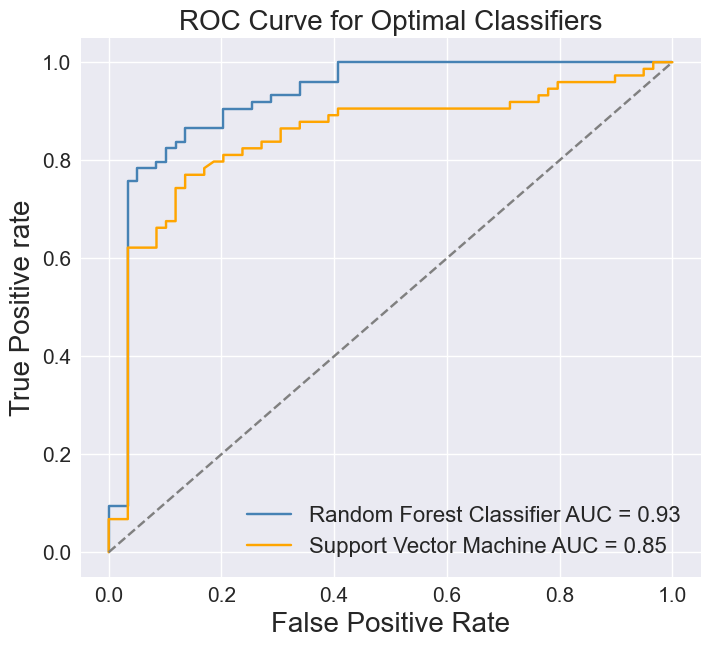

In [83]:
# Plot ROC curve for optimal classifiers
plt.style.use('seaborn')
fig = plt.figure(figsize=(8,7))

# Plot ROC curves
plt.plot(fpr_rf, tpr_rf, color='steelblue', label=f'Random Forest Classifier AUC = {rf_auc}')
plt.plot(fpr_svm, tpr_svm, color='orange', label=f'Support Vector Machine AUC = {svm_auc}')
plt.plot(p_fpr, p_tpr, linestyle='--', color='grey')

# Format plot
plt.title('ROC Curve for Optimal Classifiers', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive rate', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best', fontsize=16)

plt.show()

In [84]:
# Save ROC curve
fig.savefig('ROC.png',bbox_inches='tight')

### Optimised Hyper Parameters Table

In [85]:
# Sort hyperparameters
svm_params = {k: svm_params[k] for k in sorted(svm_params)}
rf_params = {k: rf_params[k] for k in sorted(rf_params)}

# Print hyperparameter grid
print(svm_params)
print(rf_params)

{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']}
{'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 4, 5], 'min_samples_split': [1, 2, 4, 5], 'n_estimators': [100, 200, 500]}


In [86]:
# Sort optimal hyper parameters
svm_sfs_best_params = {k: svm_sfs_best_params[k] for k in sorted(svm_sfs_best_params)}
rf_sfs_best_params = {k: rf_sfs_best_params[k] for k in sorted(rf_sfs_best_params)}

# Print optimised hyper parameters
print(svm_sfs_best_params)
print(rf_sfs_best_params)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}


In [87]:
# Extract useful metrics for dataframe
svm_params_list = [f'{key}: {value}' for key, value in svm_params.items()]
rf_params_list = [f'{key}: {value}' for key, value in rf_params.items()]
svm_params_optimal = [value for value in svm_sfs_best_params.values()]
rf_params_optimal = [value for value in rf_sfs_best_params.values()]

In [88]:
# Create dataframe to store hyperparameter information
df_hp = pd.DataFrame({
    'Classifier': ['Support Vector Machine'] * len(svm_params_list) + ['Random Forest Classifier'] * len(rf_params_list),
    'Hyperparameter Range': svm_params_list + rf_params_list,
    'Optimal Value': svm_params_optimal + rf_params_optimal
})

# Group the dataframe by the 'Classifier' column and select the first row of each group
df_grouped = df_hp.groupby(['Classifier', 'Hyperparameter Range','Optimal Value']).sum()
df_grouped

Empty DataFrame
Columns: []
Index: [(Random Forest Classifier, criterion: ['gini', 'entropy'], entropy), (Random Forest Classifier, max_depth: [2, 4, 6, 8, 10], 10), (Random Forest Classifier, min_samples_leaf: [1, 2, 4, 5], 1), (Random Forest Classifier, min_samples_split: [1, 2, 4, 5], 4), (Random Forest Classifier, n_estimators: [100, 200, 500], 100), (Support Vector Machine, C: [0.001, 0.01, 0.1, 1, 10, 100], 1), (Support Vector Machine, gamma: [0.001, 0.01, 0.1, 1, 10, 100], 1), (Support Vector Machine, kernel: ['rbf', 'linear'], rbf)]

### Sensitivity Analysis

#### ROC Curve

In [89]:
# Initialise estimators
svm = SVC(probability=True, random_state=0)
rf = RandomForestClassifier(random_state=0)

In [90]:
# Printing best hyperparameters for each classifier
print(rf_sfs_best_params)
print(svm_sfs_best_params)

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [91]:
# Create new hyperparameter grids to compare with best classifier
rf_params_1 = {'criterion': 'gini',
               'max_depth': 2,
               'min_samples_leaf': 5,
               'min_samples_split': 2,
               'n_estimators': 100}

rf_params_2 = {'criterion': 'gini',
               'max_depth': 4,
               'min_samples_leaf': 4,
               'min_samples_split': 2,
               'n_estimators': 200}

svm_params_1 = {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
svm_params_2 = {'C': 100, 'gamma': 100, 'kernel': 'rbf'}

In [92]:
# Function to run each classifier with feature selection and extract results
def run_model_sfs(X, y, classifier, params, n, experiment):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Feature Selection using SBS
    sfs = SequentialFeatureSelector(classifier, n_features_to_select=n, direction='backward')
    sfs.fit(X_train, y_train)

    # Selecting top features
    X_train = X_train.iloc[:, sfs.get_support()]
    X_test = X_test.iloc[:, sfs.get_support()]

    # Grid search to find the best parameters
    np.random.seed(0)
    grid_search = GridSearchCV(classifier, params, cv=10, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train) 

    # Create SVM classifier with best hyperparameters
    if classifier == svm:
        class_name = 'Support Vector Machine'
        best_params = grid_search.best_params_
        b_clf = SVC(**best_params, probability=True, random_state=0)

    # Create Random Forest with best hyperparameters
    if classifier == rf:
        class_name = 'Random Forest Classifier'
        best_params = grid_search.best_params_
        b_clf = RandomForestClassifier(**best_params, random_state=0)

    # Fit best classifier to the training set
    clf = b_clf.fit(X_train, y_train)

    # Make predictions
    predictions = clf.predict(X_test)

    # Generate class probabilties to calculate AUC
    y_proba = clf.predict_proba(X_test)
    
    # Generate confusion matrix and save matrix classes
    conf_matrix = confusion_matrix(y_test, predictions)
    TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

    # Generate performance metrics
    f1score = np.round((f1_score(y_test, predictions))*100, 2)
    ROC_AUC = np.round((roc_auc_score(y_test, y_proba[:, 1]))*100, 2)
    precision = np.round((precision_score(y_test, predictions))*100, 2)
    recall = np.round(recall_score(y_test, predictions)*100, 2)

    # Create summary dataframe
    result = pd.DataFrame({
        'Classifier': [class_name],
        'Precision (%)': [precision],
        'Recall (%)': [recall],
        'F1 Score (%)': [f1score],
        'ROC_AUC (%)': [ROC_AUC],
        'Experiment': [experiment]

    })

    return result, conf_matrix, best_params, sfs, clf, y_proba


In [93]:
# Function to create ROC curve per hyperparameter grid
def sensitivity_analysis(X, y, classifier, params, n, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Feature Selection using SBS
    sfs = SequentialFeatureSelector(classifier, n_features_to_select=n, direction='backward', n_jobs=-1)
    sfs.fit(X_train, y_train)

    # Selecting top features
    X_train = X_train.iloc[:, sfs.get_support()]
    X_test = X_test.iloc[:, sfs.get_support()]

    np.random.seed(0)
    
    # Create SVM classifier with selected hyperparameters
    if classifier == svm:
        class_name = f'Support Vector Machine {model_name}'
        p_clf = SVC(**params, probability=True, random_state=0)

    # Create Random Forest with selected hyperparameters
    if classifier == rf:
        class_name = f'Random Forest Classifier {model_name}'
        p_clf = RandomForestClassifier(**params, random_state=0)

    # Fit classifier to the training set
    clf = p_clf.fit(X_train, y_train)

    # Make predictions
    predictions = clf.predict(X_test)

    # Generate class probabilties to calculate AUC
    y_proba = clf.predict_proba(X_test)

    # Generate confusion matrix and save matrix classes
    conf_matrix = confusion_matrix(y_test, predictions)
    TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

    # Generate performance metrics
    f1score = np.round((f1_score(y_test, predictions))*100, 2)
    ROC_AUC = np.round((roc_auc_score(y_test, y_proba[:, 1]))*100, 2)
    precision = np.round((precision_score(y_test, predictions))*100, 2)
    recall = np.round(recall_score(y_test, predictions)*100, 2)

    # Calculate false positive rate, true positive rate and thresholds for ROC curve
    fpr, tpr, thresh = roc_curve(y_test, y_proba[:,1], pos_label=1)

    # Output dictionary of hyerparameters
    params = [f'{key}: {value}' for key, value in params.items()]
    
    # Create summary dataframe
    result = pd.DataFrame({
        'Classifier': [class_name],
        'Precision (%)': [precision],
        'Recall (%)': [recall],
        'F1 Score (%)': [f1score],
        'ROC_AUC (%)': [ROC_AUC],
        'Hyperparameters': [params]

    })

    return result, ROC_AUC, fpr, tpr, thresh


In [94]:
# Extract results for each hyperparameter grid for SVM
svm_result_1, svm_roc_auc_1, svm_fpr_1, svm_tpr_1, svm_thres_1 = sensitivity_analysis(X_bal, y_bal, svm, svm_params_1, 7, 'SVM Model 1')
svm_result_2, svm_roc_auc_2, svm_fpr_2, svm_tpr_2, svm_thres_2 = sensitivity_analysis(X_bal, y_bal, svm, svm_params_2, 7, 'SVM Model 2')

# Extract results for each hyperparameter grid for Random Forest
rf_result_1, rf_roc_auc_1, rf_fpr_1, rf_tpr_1, rf_thres_1 = sensitivity_analysis(X_bal, y_bal, rf, rf_params_1, 8, 'RF Model 1')
rf_result_2, rf_roc_auc_2, rf_fpr_2, rf_tpr_2, rf_thres_2 = sensitivity_analysis(X_bal, y_bal, rf, rf_params_2, 8, 'RF Model 2')

In [95]:
# Update ROC_AUC scores
svm_auc_1 = np.round(svm_roc_auc_1/100, 2)
svm_auc_2 = np.round(svm_roc_auc_2/100, 2)
rf_auc_1 = np.round(rf_roc_auc_1/100, 2)
rf_auc_2 = np.round(rf_roc_auc_2/100, 2)

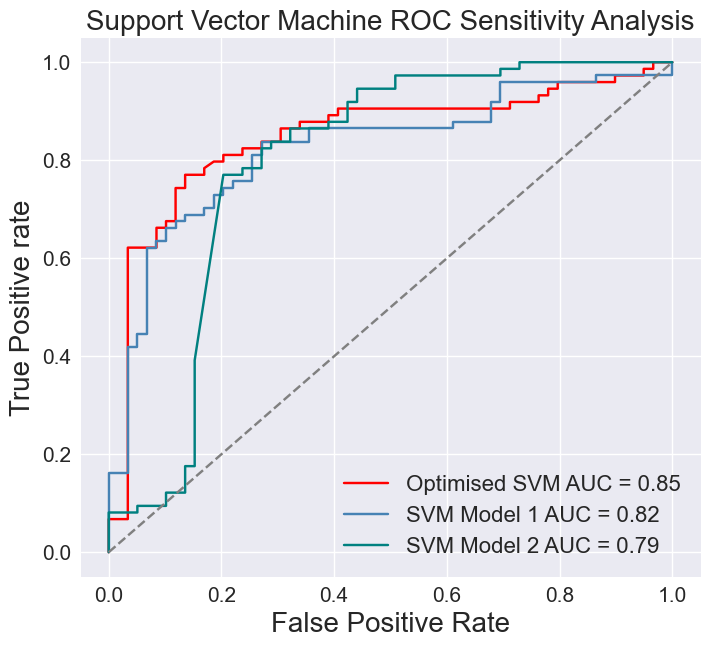

In [96]:
# Plot ROC sensitivity analysis for SVM
plt.style.use('seaborn')
fig = plt.figure(figsize=(8,7))

# Plot ROC curves for each model
plt.plot(fpr_svm, tpr_svm, color='red', label=f'Optimised SVM AUC = {svm_auc}')
plt.plot(svm_fpr_1, svm_tpr_1, color='steelblue', label=f'SVM Model 1 AUC = {svm_auc_1}')
plt.plot(svm_fpr_2, svm_tpr_2, color='teal', label=f'SVM Model 2 AUC = {svm_auc_2}')
plt.plot(p_fpr, p_tpr, linestyle='--', color='grey')

# Format plot
plt.title('Support Vector Machine ROC Sensitivity Analysis', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive rate', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right', fontsize=16)

plt.show()


In [97]:
# Save SVM sensitivity analysis
fig.savefig('SVM-ROC-SA.png',bbox_inches='tight')

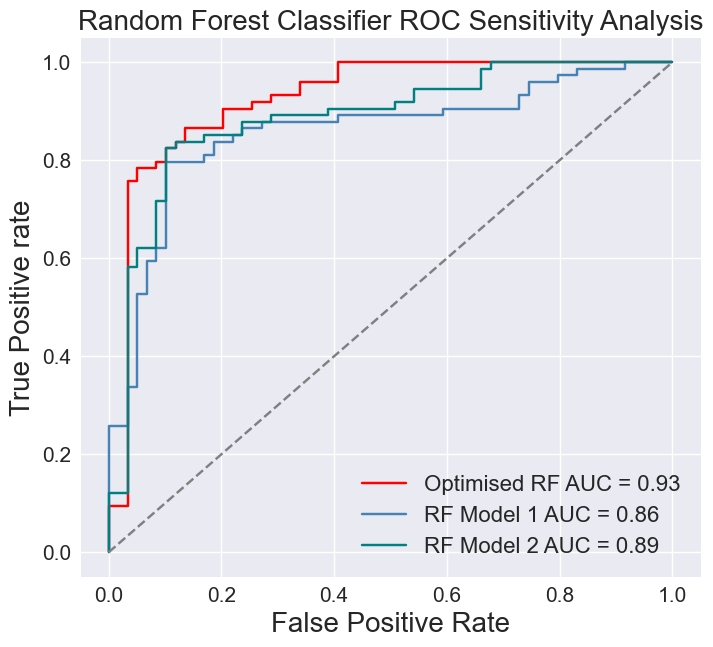

In [98]:
# Plot ROC sensitivity analysis for SVM
plt.style.use('seaborn')
fig = plt.figure(figsize=(8,7))

# Plot ROC curves for each model
plt.plot(fpr_rf, tpr_rf, color='red', label=f'Optimised RF AUC = {rf_auc}')
plt.plot(rf_fpr_1, rf_tpr_1, color='steelblue', label=f'RF Model 1 AUC = {rf_auc_1}')
plt.plot(rf_fpr_2, rf_tpr_2, color='teal', label=f'RF Model 2 AUC = {rf_auc_2}')
plt.plot(p_fpr, p_tpr, linestyle='--', color='grey')

# Format plot
plt.title('Random Forest Classifier ROC Sensitivity Analysis', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive rate', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right', fontsize=16)

plt.show()

In [99]:
# Save Random Forest sensitivity analysis
fig.savefig('RF-ROC-SA.png', bbox_inches='tight')

#### Summary Table for Hyperparameters

In [100]:
# Format optimal hyperparameter grid for each classifier
svm_optimal = [f'{key}: {value}' for key, value in svm_sfs_best_params.items()]
rf_optimal = [f'{key}: {value}' for key, value in rf_sfs_best_params.items()]

# Insert optimal hyperparameters for each classifier into summary dataframe
svm_sfs_result['Hyperparameters'] = str(svm_optimal)
rf_sfs_result['Hyperparameters'] = str(rf_optimal)

# Update classifier name for optimal models
svm_sfs_result['Classifier'] = 'Support Vector Machine Optimal'
rf_sfs_result['Classifier'] = 'Random Forest Classifier Optimal'

# Drop 'Experiment' column from previous results dataframe
svm_optimal_res = svm_sfs_result.drop(columns=['Experiment'])
rf_optimal_res = rf_sfs_result.drop(columns=['Experiment'])

In [101]:
# Concatenate results and create hyperparameter summary dataframe
hp_summary = pd.concat([svm_optimal_res, svm_result_1, svm_result_2, rf_optimal_res, rf_result_1, rf_result_2], ignore_index=True)
hp_summary

,Classifier,Precision (%),Recall (%),F1 Score (%),ROC_AUC (%),Hyperparameters
0,Support Vector Machine Optimal,88.52,72.97,80.00,84.76,"['C: 1', 'gamma: 1', 'kernel: rbf']"
1,Support Vector Machine SVM Model 1,91.67,59.46,72.13,82.43,"[C: 0.1, gamma: 0.1, kernel: rbf]"
2,Support Vector Machine SVM Model 2,67.29,97.30,79.56,79.48,"[C: 100, gamma: 100, kernel: rbf]"
3,Random Forest Classifier Optimal,95.08,78.38,85.93,92.58,"['criterion: entropy', 'max_depth: 10', 'min_s..."
4,Random Forest Classifier RF Model 1,88.68,63.51,74.02,85.80,"[criterion: gini, max_depth: 2, min_samples_le..."
5,Random Forest Classifier RF Model 2,91.38,71.62,80.30,88.64,"[criterion: gini, max_depth: 4, min_samples_le..."
